In [1]:
%matplotlib inline

import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import pickle
import pandas as pd
import scipy.io
import time
import h5py
import bz2
import multiprocessing as mp


from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

from numpy import linalg as LA
from scipy.spatial import Delaunay
from sklearn.neighbors import NearestNeighbors, KDTree

from sklearn import metrics
from sklearn.metrics import f1_score, precision_score, recall_score, matthews_corrcoef
from sklearn.metrics import auc

#sys.path.insert(0, "../")
from info3d import *
from nn_matchers import *

# Extracting the point collection and the descriptors

In [2]:
with open('point_collection/new_contiguous_point_collection.pickle','rb') as f: 
    new_contiguous_point_collection = pickle.load(f)
    
with open('descriptors/new_complete_res5_4by5_descriptors.pickle','rb') as f:
    descriptors = pickle.load(f)
    
with open('descriptors/new_complete_RANSAC_res5_4by5_descriptors.pickle','rb') as f:
    ransac_descriptors = pickle.load(f)
    
results_path = 'testing_results'

if not os.path.exists(results_path): os.mkdir(results_path)
    
obj_names = []

for obj_name, pointCloud, triangles in new_contiguous_point_collection:
    obj_names.append(obj_name)
    
contiguous_names_short = [
    'Recpt\'n',
    'Drvway',
    'Aprtmnt',
    'Wrkst\'n',
    'Kitchen',
    'Hallway',
    'Strwell',
]

contiguous_names = [
    'Reception',
    'Driveway',
    'Apartment',
    'Workstation',
    'Kitchen',
    'Hallway',
    'Stairwell',
]

colors = [
    "tab:blue",
    "tab:orange",
    "tab:green",
    "tab:red",
    "tab:purple",
    "tab:cyan",
    "tab:olive",
    "tab:gray",
    "tab:pink",
    "tab:brown"
]

obj_names

['Reception-Data61-L5.obj',
 'Driveway.obj',
 'Apartment.obj',
 'Workstations-Data61-L4.obj',
 'Kitchen-Data61-L4.obj',
 'HallWayToKitchen-Data61-L4.obj',
 'StairWell-Data61-L4.obj']

# Performance Scores

# NN-matcher Results

In [187]:
# Hololens data

results_partials = [[],[]] 

raw_errors = []    
ransac_errors = []

for radius in np.arange(0.25, 5.1, 0.25):

    try:
        with bz2.BZ2File('testing_results/partial/ransac_{}_partial_scores_parallel_sample_points_2.pickle.bz2'.format(radius), 'r') as bz2_f:
            partial_scores_pool = pickle.load(bz2_f) 

    except:
        print("Error getting Raw scores for",radius)
        continue

    partial_errors_pool = NN_matcher(partial_scores_pool)
    correct_interspace_labels_idxs = np.where(partial_errors_pool[:,1]==0)[0]
    intraspace_errors  = partial_errors_pool[correct_interspace_labels_idxs,2]

    print(radius,"(Ransac) P1 Error Rate:",np.sum(partial_errors_pool[:,1])/len(partial_scores_pool)) 
    print("   (Ransac) P2 Error Rate: {:.3f} (± {:.3f})".format(np.nanmean(intraspace_errors),np.nanstd(intraspace_errors))) 
    
    ransac_errors.append([
        radius,
        partial_errors_pool
    ])
    
    results_partials[1].append([
        radius,
        np.sum(partial_errors_pool[:,1])/len(partial_scores_pool),
        np.nanmean(intraspace_errors),
        np.nanstd(intraspace_errors)
    ])
    
    try:
        with bz2.BZ2File('testing_results/partial/raw_{}_partial_scores.pickle.bz2'.format(radius), 'r') as bz2_f:
            partial_scores_pool = pickle.load(bz2_f) 
            
    except:
        print("Error getting Raw scores for",radius)
        continue

    partial_errors_pool = NN_matcher(partial_scores_pool)
    correct_interspace_labels_idxs = np.where(partial_errors_pool[:,1]==0)[0]
    intraspace_errors  = partial_errors_pool[correct_interspace_labels_idxs,2]

    print(radius,"(Raw) P1 Error Rate:",np.sum(partial_errors_pool[:,1])/len(partial_scores_pool)) 
    print("   (Raw) P2 Error Rate: {:.3f} (± {:.3f})".format(np.nanmean(intraspace_errors),np.nanstd(intraspace_errors))) 
    
    results_partials[0].append([
        radius,
        np.sum(partial_errors_pool[:,1])/len(partial_scores_pool),
        np.nanmean(intraspace_errors),
        np.nanstd(intraspace_errors)
    ])
    
    raw_errors.append([
        radius,
        partial_errors_pool
    ])
    
with open('testing_results/partial/results_partials_nn_matcher_1000.pickle', 'wb') as f:
    pickle.dump([results_partials, raw_errors, ransac_errors],f)


0.25 (Ransac) P1 Error Rate: 0.8909774436090225
   (Ransac) P2 Error Rate: 5.566 (± 1.549)
0.25 (Raw) P1 Error Rate: 0.8458646616541353
   (Raw) P2 Error Rate: 4.972 (± 1.552)
0.5 (Ransac) P1 Error Rate: 0.8473895582329317
   (Ransac) P2 Error Rate: 5.551 (± 2.716)
Error getting Raw scores for 0.5
0.75 (Ransac) P1 Error Rate: 0.7894736842105263
   (Ransac) P2 Error Rate: 4.154 (± 3.322)
0.75 (Raw) P1 Error Rate: 0.6917293233082706
   (Raw) P2 Error Rate: 3.748 (± 3.658)
1.0 (Ransac) P1 Error Rate: 0.6062124248496994
   (Ransac) P2 Error Rate: 2.916 (± 3.255)
Error getting Raw scores for 1.0
1.25 (Ransac) P1 Error Rate: 0.47368421052631576
   (Ransac) P2 Error Rate: 1.797 (± 2.289)
1.25 (Raw) P1 Error Rate: 0.05639097744360902
   (Raw) P2 Error Rate: 1.043 (± 1.182)
1.5 (Ransac) P1 Error Rate: 0.334
   (Ransac) P2 Error Rate: 1.529 (± 1.817)
Error getting Raw scores for 1.5
1.75 (Ransac) P1 Error Rate: 0.23308270676691728
   (Ransac) P2 Error Rate: 1.367 (± 1.266)
1.75 (Raw) P1 Error Ra

In [51]:
partial_errors_pool = ransac_errors[0][1]
np.unique(partial_errors_pool[:,0]),np.unique(partial_errors_pool[:,3])

(array([0., 1., 2., 3., 4., 5., 6.]), array([0., 1., 2., 3., 4., 5., 6.]))

In [3]:
with open('testing_results/partial/results_partials_nn_matcher_1000.pickle', 'rb') as f:
    results_partials, raw_errors, ransac_errors = pickle.load(f)

per_space_score = []
perf_scores = []

#desired_r = [0.5, 1.0, 3.0]

for radius, partial_errors in ransac_errors:

    score_map = np.zeros((7,7))

    for score in partial_errors:
        score_map[int(score[0]),int(score[3])]+=1
        
    macro_score = f1_score(partial_errors[:,0],partial_errors[:,3],average='macro')
    micro_score = f1_score(partial_errors[:,0],partial_errors[:,3],average='micro')
    mcc = matthews_corrcoef(partial_errors[:,0],partial_errors[:,3])
    ave_prec_score = precision_score(partial_errors[:,0],partial_errors[:,3],average='macro')
    prec_score = precision_score(partial_errors[:,0],partial_errors[:,3],average=None)
    ave_recl_score = recall_score(partial_errors[:,0],partial_errors[:,3],average='macro')
    recl_score = recall_score(partial_errors[:,0],partial_errors[:,3],average=None)
    
    per_space_score.append([
        f1_score(partial_errors[:,0],partial_errors[:,3],average=None),
        prec_score,
        recl_score
    ])
    
    perf_scores.append([
        radius,
        macro_score,
        micro_score,
        mcc,
        (np.sum(score_map) - np.trace(score_map))/np.sum(score_map)
    ])
    
per_space_score = np.asarray(per_space_score)
perf_scores = np.asarray(perf_scores)

with open("testing_results/partial/" + "summary_results_1000.pickle",'wb') as f:
    pickle.dump([results_partials, per_space_score, perf_scores],f)
    

/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [42]:
# Results for ARCore dataset

arcore_results_partials = []

#raw_errors = []    
arcore_ransac_errors = []

with open('../../spatial-privacy/descriptors/chosen_arcore_res5_4by5_descriptors_complete.pickle','rb') as f:
    arcore_descriptors = pickle.load(f)

for radius in np.arange(0.25, 3.1, 0.25):

    try:
        with bz2.BZ2File("testing_results/nn_matcher_arcore/{}_partial_scores.pickle.bz2".format(radius), 'r') as bz2_f:
            partial_scores_pool = pickle.load(bz2_f) 

    except:
        print("Error getting arcore scores for",radius)
        continue

    partial_errors_pool = ARcore_NNMatcher(partial_scores_pool, arcore_descriptors[:-1])
    correct_interspace_labels_idxs = np.where(partial_errors_pool[:,1]==0)[0]
    intraspace_errors  = partial_errors_pool[correct_interspace_labels_idxs,2]

    print(radius,"(Ransac) P1 Error Rate:",np.sum(partial_errors_pool[:,1])/len(partial_scores_pool)) 
    print("   (Ransac) P2 Error Rate: {:.3f} (± {:.3f})".format(np.nanmean(intraspace_errors),np.nanstd(intraspace_errors))) 

    arcore_results_partials.append([
        radius,
        np.sum(partial_errors_pool[:,1])/len(partial_scores_pool),
        np.nanmean(intraspace_errors),
        np.nanstd(intraspace_errors)
    ])
    
    arcore_ransac_errors.append([
        radius,
        partial_errors_pool
    ])
    
with open("testing_results/nn_matcher_arcore/results_partials_nn_matcher.pickle", 'wb') as f:
    pickle.dump([arcore_results_partials, arcore_ransac_errors],f)

/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:386: RuntimeWarning: Mean of empty slice
  LA.norm(np.nanmean(best_ref_kps[:,:3], axis = 0) - obj_meta[2][:3]),


0.25 (Ransac) P1 Error Rate: 0.8497983870967742
   (Ransac) P2 Error Rate: 2.102 (± 0.890)
0.5 (Ransac) P1 Error Rate: 0.8598790322580645
   (Ransac) P2 Error Rate: 7.348 (± 4.058)
0.75 (Ransac) P1 Error Rate: 0.8397177419354839
   (Ransac) P2 Error Rate: 7.695 (± 4.512)
1.0 (Ransac) P1 Error Rate: 0.8316532258064516
   (Ransac) P2 Error Rate: 6.878 (± 4.677)
1.25 (Ransac) P1 Error Rate: 0.7993951612903226
   (Ransac) P2 Error Rate: 5.384 (± 4.314)
1.5 (Ransac) P1 Error Rate: 0.7752016129032258
   (Ransac) P2 Error Rate: 4.820 (± 4.324)
1.75 (Ransac) P1 Error Rate: 0.7449596774193549
   (Ransac) P2 Error Rate: 4.680 (± 4.463)
2.0 (Ransac) P1 Error Rate: 0.7258064516129032
   (Ransac) P2 Error Rate: 4.437 (± 4.405)
2.25 (Ransac) P1 Error Rate: 0.7217741935483871
   (Ransac) P2 Error Rate: 4.490 (± 4.538)
2.5 (Ransac) P1 Error Rate: 0.7086693548387096
   (Ransac) P2 Error Rate: 3.947 (± 4.204)
2.75 (Ransac) P1 Error Rate: 0.7147177419354839
   (Ransac) P2 Error Rate: 4.092 (± 4.212)
3.0 

In [50]:
partial_errors_pool = arcore_ransac_errors[3][1]
np.unique(partial_errors_pool[:,0]),np.unique(partial_errors_pool[:,3])

(array([0, 1, 2, 3, 4, 5, 6], dtype=object),
 array([0, 1, 2, 3, 4, 5, 6], dtype=object))

In [53]:
arcore_nn_per_space_score = []
arcore_nn_perf_scores = []

#desired_r = [0.5, 1.0, 3.0]

for radius, partial_errors in arcore_ransac_errors:
    
    partial_errors = np.asarray(partial_errors[:,[0,3]], dtype=int)

    score_map = np.zeros((7,7))

    for score in partial_errors:
        score_map[int(score[0]),int(score[1])]+=1
        
    macro_score = f1_score(partial_errors[:,0],partial_errors[:,1],average='macro')
    micro_score = f1_score(partial_errors[:,0],partial_errors[:,1],average='micro')
    mcc = matthews_corrcoef(partial_errors[:,0],partial_errors[:,1])
    ave_prec_score = precision_score(partial_errors[:,0],partial_errors[:,1],average='macro')
    prec_score = precision_score(partial_errors[:,0],partial_errors[:,1],average=None)
    ave_recl_score = recall_score(partial_errors[:,0],partial_errors[:,1],average='macro')
    recl_score = recall_score(partial_errors[:,0],partial_errors[:,1],average=None)

    arcore_nn_per_space_score.append([
        f1_score(partial_errors[:,0],partial_errors[:,1],average=None),
        prec_score,
        recl_score
    ])

    arcore_nn_perf_scores.append([
        radius,
        macro_score,
        micro_score,
        mcc,
        (np.sum(score_map) - np.trace(score_map))/np.sum(score_map)
    ])

    
arcore_nn_per_space_score = np.asarray(arcore_nn_per_space_score)
arcore_nn_perf_scores = np.asarray(arcore_nn_perf_scores)

with open("testing_results/nn_matcher_arcore/" + "summary_results.pickle",'wb') as f:
    pickle.dump([arcore_results_partials, arcore_nn_per_space_score, arcore_nn_perf_scores],f)
    

/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# PointnetVLAD results

In [332]:
RESULTS_FOLDER="testing_results/pointnetvlad_prod/"
if not os.path.exists(RESULTS_FOLDER): os.mkdir(RESULTS_FOLDER)   

pickle_file = 'partial_results_updated_refs.pickle'

try:
    with open(RESULTS_FOLDER + pickle_file,'rb') as pickle_output:
        results_pickle = pickle.load(pickle_output)
except:
    print("No results.")
    
pointnetvlad_results = []
pointnetvlad_per_space_score = []
pointnetvlad_perf_scores= []

for radius, recall, intra_dist, test_recall in results_pickle:
    
    pointnetvlad_results.append([
        radius,
        recall[0],
        intra_dist[0]
    ])
    
    count_diff = 0

    errors_pool = []
    
    for m, n, top1_obj_cands in test_recall:
        
        if len(errors_pool) == 0:
            errors_pool = top1_obj_cands
        else:
            errors_pool = np.concatenate((errors_pool,top1_obj_cands), axis = 0)
            
        #print("  ",m,n,len(top1_obj_cands),len(errors_pool))
        
    macro_score = f1_score(errors_pool[:,0],errors_pool[:,1],average='macro')    
    micro_score = f1_score(errors_pool[:,0],errors_pool[:,1],average='micro')
    mcc = matthews_corrcoef(errors_pool[:,0],errors_pool[:,1])
    ave_prec_score = precision_score(errors_pool[:,0],errors_pool[:,1],average='macro')
    prec_score = precision_score(errors_pool[:,0],errors_pool[:,1],average=None)
    ave_recl_score = recall_score(errors_pool[:,0],errors_pool[:,1],average='macro')
    recl_score = recall_score(errors_pool[:,0],errors_pool[:,1],average=None)
    
    pointnetvlad_per_space_score.append([
        f1_score(errors_pool[:,0],errors_pool[:,1],average=None),
        prec_score,
        recl_score
    ])
    
    pointnetvlad_perf_scores.append([
        radius,
        macro_score,
        micro_score,
        mcc
        #(np.sum(score_map) - np.trace(score_map))/np.sum(score_map)
    ])

    1 - count_diff/len(test_recall)
    
    
pointnetvlad_results = np.asarray(pointnetvlad_results)
pointnetvlad_per_space_score = np.asarray(pointnetvlad_per_space_score)
pointnetvlad_perf_scores = np.asarray(pointnetvlad_perf_scores)

with open("testing_results/pointnetvlad_prod/" + "summary_results.pickle",'wb') as f:
    pickle.dump([pointnetvlad_results, pointnetvlad_per_space_score, pointnetvlad_perf_scores],f)
    


/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [355]:
RESULTS_FOLDER="testing_results/pointnetvlad_prod_2/"
if not os.path.exists(RESULTS_FOLDER): os.mkdir(RESULTS_FOLDER)   
    
pickle_file = 'partial_results_updated_refs_2_0.5.pickle'

try:
    with open(RESULTS_FOLDER + pickle_file,'rb') as pickle_output:
        results_pickle = pickle.load(pickle_output)
except:
    print("No results.")
    
pointnetvlad_results = []
pointnetvlad_per_space_score = []
pointnetvlad_perf_scores= []

for radius, recall, intra_dist, test_recall in results_pickle:
    
    pointnetvlad_results.append([
        radius,
        recall[0],
        intra_dist[0]
    ])
    
    count_diff = 0

    errors_pool = []
    
    for m, n, top1_obj_cands in test_recall:
        
        """
        if len(errors_pool) == 0:
            errors_pool = top1_obj_cands
        else:
            errors_pool = np.concatenate((errors_pool,top1_obj_cands), axis = 0)
        """
        
        for original_vertex, orig_label, cand_label in top1_obj_cands:
            
            #print(radius, m ,n, original_vertex, orig_label, cand_label)

            per_obj_label = []
            per_obj_label.append(orig_label)
            per_obj_label.append(cand_label)
            per_obj_label.append(original_vertex[0])
            per_obj_label.append(original_vertex[1])
            per_obj_label.append(original_vertex[2])
            errors_pool.append(per_obj_label)
            
        #print("  ",m,n,len(top1_obj_cands),len(errors_pool))
    errors_pool = np.asarray(errors_pool)
    
    #print(errors_pool)
    
    macro_score = f1_score(errors_pool[:,0],errors_pool[:,1],average='macro')    
    micro_score = f1_score(errors_pool[:,0],errors_pool[:,1],average='micro')
    mcc = matthews_corrcoef(errors_pool[:,0],errors_pool[:,1])
    ave_prec_score = precision_score(errors_pool[:,0],errors_pool[:,1],average='macro')
    prec_score = precision_score(errors_pool[:,0],errors_pool[:,1],average=None)
    ave_recl_score = recall_score(errors_pool[:,0],errors_pool[:,1],average='macro')
    recl_score = recall_score(errors_pool[:,0],errors_pool[:,1],average=None)
    
    pointnetvlad_per_space_score.append([
        f1_score(errors_pool[:,0],errors_pool[:,1],average=None),
        prec_score,
        recl_score
    ])
    
    pointnetvlad_perf_scores.append([
        radius,
        macro_score,
        micro_score,
        mcc
        #(np.sum(score_map) - np.trace(score_map))/np.sum(score_map)
    ])

    1 - count_diff/len(test_recall)
    
pointnetvlad_results = np.asarray(pointnetvlad_results)
pointnetvlad_per_space_score = np.asarray(pointnetvlad_per_space_score)
pointnetvlad_perf_scores = np.asarray(pointnetvlad_perf_scores)

with open("testing_results/pointnetvlad_prod/" + "summary_results_updated.pickle",'wb') as f:
    pickle.dump([pointnetvlad_results, pointnetvlad_per_space_score, pointnetvlad_perf_scores],f)
    

/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [92]:
#ARCORE REsults

RESULTS_FOLDER="testing_results/pointnetvlad_arcore/"
    
pickle_file = 'partial_results.pickle'

try:
    with open(RESULTS_FOLDER + pickle_file,'rb') as pickle_output:
        results_pickle = pickle.load(pickle_output)
except:
    print("No results.")
    
arcore_pv_results = []
arcore_pv_per_space_score = []
arcore_pv_perf_scores = []

for radius, recall, intra_dist, test_recall in results_pickle:
    
    arcore_pv_results.append([
        radius,
        recall[0],
        intra_dist[0]
    ])
    
    count_diff = 0

    errors_pool = []
    
    for m, n, top1_obj_cands in test_recall:
        if len(errors_pool) == 0:
            errors_pool = top1_obj_cands
        else:
            errors_pool = np.concatenate((errors_pool,top1_obj_cands), axis = 0)
            
        #print("  ",m,n,len(top1_obj_cands),len(errors_pool))
        
    macro_score = f1_score(errors_pool[:,0],errors_pool[:,1],average='macro')    
    micro_score = f1_score(errors_pool[:,0],errors_pool[:,1],average='micro')
    mcc = matthews_corrcoef(errors_pool[:,0],errors_pool[:,1])
    ave_prec_score = precision_score(errors_pool[:,0],errors_pool[:,1],average='macro')
    prec_score = precision_score(errors_pool[:,0],errors_pool[:,1],average=None)
    ave_recl_score = recall_score(errors_pool[:,0],errors_pool[:,1],average='macro')
    recl_score = recall_score(errors_pool[:,0],errors_pool[:,1],average=None)
    
    arcore_pv_per_space_score.append([
        f1_score(errors_pool[:,0],errors_pool[:,1],average=None),
        prec_score,
        recl_score
    ])
    
    arcore_pv_perf_scores.append([
        radius,
        macro_score,
        micro_score,
        mcc
        #(np.sum(score_map) - np.trace(score_map))/np.sum(score_map)
    ])

    1 - count_diff/len(test_recall)
    
    
arcore_pv_results = np.asarray(arcore_pv_results)
arcore_pv_per_space_score = np.asarray(arcore_pv_per_space_score)
arcore_pv_perf_scores = np.asarray(arcore_pv_perf_scores)

with open("testing_results/pointnetvlad_arcore/" + "arcore_summary_results.pickle",'wb') as f:
    pickle.dump([arcore_pv_results, arcore_pv_per_space_score, arcore_pv_perf_scores],f)
    

/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [328]:
fig=plt.figure(figsize=(4,2.5))

with open(RESULTS_FOLDER + "summary_results_updated.pickle",'rb') as f:
    [pointnetvlad_results, pointnetvlad_per_space_score] = pickle.load(f)

ax1 = fig.add_subplot(1,1,1)

im1 = ax1.imshow(
    pointnetvlad_per_space_score[:,0].T,
    vmin=0, vmax=1.0, aspect='auto',
    cmap = plt.cm.viridis
)

# Create divider for existing axes instance
divider1 = make_axes_locatable(ax1)
# Append axes to the right of ax3, with 20% width of ax3
cax1 = divider1.append_axes("right", size="3%", pad=0.1)

# Create colorbar in the appended axes
# Tick locations can be set with the kwarg `ticks`
# and the format of the ticklabels with kwarg `format`
cbar1 = plt.colorbar(im1, cax=cax1, ticks=np.arange(0,1.6,0.2), format="%.2f")
#cbar1.ax.set_ylabel("F1-score", fontsize = 14)
cbar1.ax.set_yticklabels(np.arange(0,1.6,0.2, dtype = np.float32),fontsize = 14)

#cbar = plt.colorbar(ticks = np.arange(0,1.1,0.2))
#cbar.ax.set_ylabel("F1-score", fontsize = 14)
#cbar.ax.set_yticklabels(np.arange(0,1.1,0.2, dtype = np.float32),fontsize = 14)

ax1.set_title('F1-Score\n (Generalized, pointnetVLAD', fontsize = 14)
ax1.set_xticks(np.arange(len(results_pickle)))
ax1.set_xticklabels(np.arange(0.25, 3.1, 0.25),rotation = 60,fontsize = 12)
ax1.set_xlabel('Partial radius', fontsize = 14)
ax1.set_yticks(np.arange(0,7,1))
#plt.yticks(np.arange(0,7,1),contiguous_names_short,fontsize = 12)
ax1.set_yticklabels(contiguous_names_short,fontsize = 12)
#plt.yticklabels(

#plt.xlabel('Partial radius', fontsize = 14)
#plt.xticks(np.arange(0,6),np.arange(0.25, 1.6, 0.25),fontsize = 14)
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'testing_results/pointnetvlad_prod_2/summary_results_updated.pickle'

<Figure size 288x180 with 0 Axes>

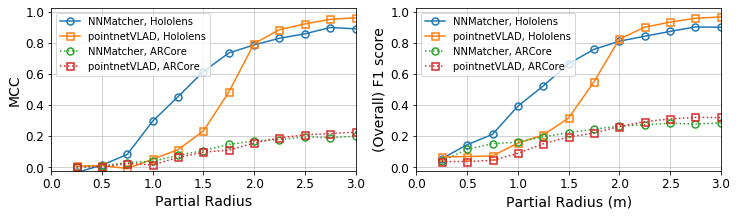

In [5]:
# Using F1 scores

fig=plt.figure(figsize=(12, 3))

with open("testing_results/pointnetvlad_arcore/" + "arcore_summary_results.pickle",'rb') as f:
    arcore_pv_results, arcore_pv_per_space_score, arcore_pv_perf_scores = pickle.load(f)
    
with open("testing_results/pointnetvlad_prod/" + "summary_results.pickle",'rb') as f:
    pointnetvlad_results, pointnetvlad_per_space_score, pointnetvlad_perf_scores = pickle.load(f)
    
with open("testing_results/partial/" + "summary_results_1000.pickle",'rb') as f:
    nn_results_partials, nn_per_space_score, nn_perf_scores = pickle.load(f)
    
with open("testing_results/nn_matcher_arcore/" + "summary_results.pickle",'rb') as f:
    arcore_results_partials, arcore_nn_per_space_score, arcore_nn_perf_scores = pickle.load(f)

    
HololensNN = nn_perf_scores
HololensPV = pointnetvlad_perf_scores
ARCoreNN = arcore_nn_perf_scores
ARCorePV = arcore_pv_perf_scores

linewidth = 2.0
markersize = 8.0

ax1 = fig.add_subplot(121)#, sharex = ax2) 

ax1.grid(alpha = 0.7)
ax1.set_ylim(-0.025,1.025)
ax1.set_xlim(0,3.0)
ax1.set_ylabel("MCC", fontsize = 14);
ax1.set_xlabel("Partial Radius", fontsize = 14);

ax1.set_xticklabels(np.arange(0,3.1,0.5),fontsize=12)
ax1.set_yticks(np.arange(0,1.1,0.2))
ax1.set_yticklabels(np.around(np.arange(0,1.1,0.2), decimals = 1),fontsize=12)

markersize = 7
linewidth = 1.5

ax1.plot(
    HololensNN[:,0],
    HololensNN[:,3], 
    linewidth = linewidth, 
    marker = 'o',fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "NNMatcher, Hololens"
)
ax1.plot(
    HololensPV[:,0],
    HololensPV[:,3],
    '-s',
    linewidth = linewidth,
    fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "pointnetVLAD, Hololens"
)

ax1.plot(
    ARCoreNN[:,0],
    ARCoreNN[:,3], 
    ':o',linewidth = linewidth, 
    fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "NNMatcher, ARCore"
)

ax1.plot(
    ARCorePV[:,0],
    ARCorePV[:,3],
    ':s',
    linewidth = linewidth,
    fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "pointnetVLAD, ARCore"
)

ax1.legend(loc = "best", ncol = 1, fontsize = 10);# bbox_to_anchor=(1.1, 1.5));

ax2 = fig.add_subplot(122)#, sharex = ax1) 

ax2.grid(alpha = 0.7)
ax2.set_ylim(-0.025,1.025)
ax2.set_xlim(0,3)

ax2.set_ylabel("(Overall) F1 score", fontsize = 14);
ax2.set_xlabel("Partial Radius (m)", fontsize = 14);

ax2.set_xticklabels(np.arange(0,3.1,0.5),fontsize=12)
ax2.set_yticks(np.arange(0,1.1,0.2))
ax2.set_yticklabels(np.around(np.arange(0,1.1,0.2), decimals = 1),fontsize=12)

#plt.minorticks_on()

ax2.plot(
    HololensNN[:,0],
    HololensNN[:,1], 
    linewidth = linewidth, 
    marker = 'o',fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "NNMatcher, Hololens"
)
ax2.plot(
    HololensPV[:,0],
    HololensPV[:,1],
    '-s',
    linewidth = linewidth,
    fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "pointnetVLAD, Hololens"
)
ax2.plot(
    ARCoreNN[:,0],
    ARCoreNN[:,1], 
    ':o',
    linewidth = linewidth, 
    fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "NNMatcher, ARCore"
)
ax2.plot(
    ARCorePV[:,0],
    ARCorePV[:,1],
    ':s',
    linewidth = linewidth,
    fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "pointnetVLAD, ARCore"
)

ax2.legend(loc = "best", ncol = 1, fontsize = 10);#, bbox_to_anchor=(1.1, 1.5));

#plt.title("NN-matcher")

#plt.savefig('plots/overall-f1-partials-radius-with-arcore.png', format='png', dpi=300,bbox_inches = 'tight')
#plt.savefig('plots/overall-f1-partials-radius-with-arcore.pdf', format='pdf', dpi=300,bbox_inches = 'tight')


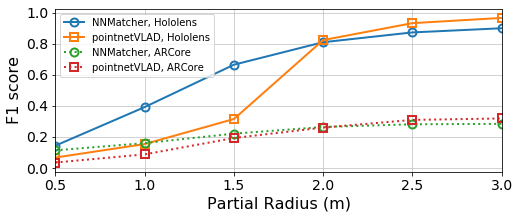

In [356]:
# Using F1 scores

fig=plt.figure(figsize=(8, 3))

with open("testing_results/pointnetvlad_arcore/" + "arcore_summary_results.pickle",'rb') as f:
    arcore_pv_results, arcore_pv_per_space_score, arcore_pv_perf_scores = pickle.load(f)
    
with open("testing_results/pointnetvlad_prod/" + "summary_results_updated.pickle",'rb') as f:
    pointnetvlad_results, pointnetvlad_per_space_score, pointnetvlad_perf_scores = pickle.load(f)
    
with open("testing_results/partial/" + "summary_results_1000.pickle",'rb') as f:
    nn_results_partials, nn_per_space_score, nn_perf_scores = pickle.load(f)
    
with open("testing_results/nn_matcher_arcore/" + "summary_results.pickle",'rb') as f:
    arcore_results_partials, arcore_nn_per_space_score, arcore_nn_perf_scores = pickle.load(f)

    
HololensNN = nn_perf_scores
HololensPV = pointnetvlad_perf_scores
ARCoreNN = arcore_nn_perf_scores
ARCorePV = arcore_pv_perf_scores

linewidth = 2.0
markersize = 8.0

ax2 = fig.add_subplot(111) 

ax2.grid(alpha = 0.7)
ax2.set_ylim(-0.025,1.025)
ax2.set_xlim(0.5,3)

ax2.set_ylabel("F1 score", fontsize = 16);
ax2.set_xlabel("Partial Radius (m)", fontsize = 16);

ax2.set_xticklabels(np.arange(0.5,3.1,0.5),fontsize=14)
ax2.set_yticks(np.arange(0,1.1,0.2))
ax2.set_yticklabels(np.around(np.arange(0,1.1,0.2), decimals = 1),fontsize=14)

#plt.minorticks_on()

ax2.plot(
    HololensNN[1::2,0],
    HololensNN[1::2,1], 
    linewidth = linewidth, 
    marker = 'o',fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "NNMatcher, Hololens"
)
ax2.plot(
    HololensPV[1::2,0],
    HololensPV[1::2,1],
    '-s',
    linewidth = linewidth,
    fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "pointnetVLAD, Hololens"
)
ax2.plot(
    ARCoreNN[1::2,0],
    ARCoreNN[1::2,1], 
    ':o',
    linewidth = linewidth, 
    fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "NNMatcher, ARCore"
)
ax2.plot(
    ARCorePV[1::2,0],
    ARCorePV[1::2,1],
    ':s',
    linewidth = linewidth,
    fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "pointnetVLAD, ARCore"
)

ax2.legend(loc = "best", ncol = 1, fontsize = 10);#, bbox_to_anchor=(1.1, 1.5));

#plt.title("NN-matcher")

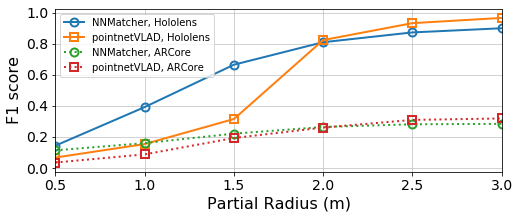

In [39]:
#plt.savefig('plots/overall-f1-partials-radius-with-arcore.png', format='png', dpi=300,bbox_inches = 'tight')
#plt.savefig('plots/overall-f1-partials-radius-with-arcore.pdf', format='pdf', dpi=300,bbox_inches = 'tight')

In [71]:
print('Hololens, NN', HololensNN[1:12:2,1])
print('Hololens, PV', HololensPV[1:12:2,1])
print('ARCore, NN', ARCoreNN[1:12:2,1])
print('ARCore, PV', ARCorePV[1:12:2,1])

Hololens, NN [0.14304344 0.39144113 0.66452766 0.80949408 0.87243358 0.89924443]
Hololens, PV [0.06667366 0.15353992 0.31465453 0.82321138 0.93209272 0.96580331]
ARCore, NN [0.11316414 0.15959665 0.22057438 0.26365282 0.28101654 0.28372453]
ARCore, PV [0.03464725 0.08717726 0.19262745 0.25962154 0.30915    0.31838326]


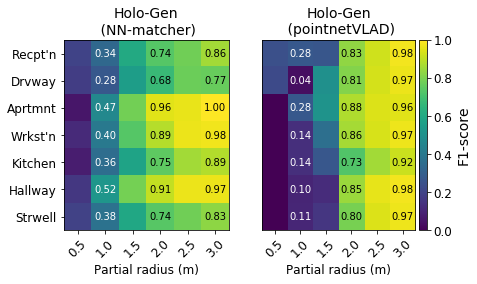

In [114]:
fig = plt.figure(figsize=(6.5,3.5))

with open("testing_results/pointnetvlad_arcore/" + "arcore_summary_results.pickle",'rb') as f:
    arcore_pv_results, arcore_pv_per_space_score, arcore_pv_perf_scores = pickle.load(f)
    
with open("testing_results/pointnetvlad_prod/" + "summary_results.pickle",'rb') as f:
    pointnetvlad_results, pointnetvlad_per_space_score, pointnetvlad_perf_scores = pickle.load(f)
    
with open("testing_results/partial/" + "summary_results_1000.pickle",'rb') as f:
    nn_results_partials, nn_per_space_score, nn_perf_scores = pickle.load(f)
    
with open("testing_results/nn_matcher_arcore/" + "summary_results.pickle",'rb') as f:
    arcore_results_partials, arcore_nn_per_space_score, arcore_nn_perf_scores = pickle.load(f)

#fig3 = plt.figure(constrained_layout=True)
#gs = fig3.add_gridspec(3, 3)
ax2 = fig.add_subplot(121)
ax3 = fig.add_subplot(122)
#fig.figsize(8,3.5)

im2 = ax2.imshow(
    nn_per_space_score[1:12:2,0].T,
    vmin=0.0, vmax=1.0, aspect='auto',
    cmap = plt.cm.viridis
)

for i, per_radius in enumerate(nn_per_space_score[3:12:4,0]):
    
    for j, value in enumerate(per_radius):
        
        color = 'black'
        
        if i == 0: color = 'white'

        ax2.text(
            i*2+1, j,
            ha="center", va="center",
            s = "{:.2f}".format(value),
            fontsize = 10,
            color = color
        )

ax2.set_title("Holo-Gen\n (NN-matcher)", fontsize = 14)
ax2.set_xticks(np.arange(6))
ax2.set_xticklabels(nn_perf_scores[1:12:2,0], rotation=45, fontsize = 12)
ax2.set_xlabel("Partial radius (m)",fontsize = 12)
ax2.set_yticks(np.arange(len(contiguous_names)))
ax2.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);
#ax2.set_yticks([])
#ax2.set_yticklabels([])
#ax2.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);

im3 = ax3.imshow(
    pointnetvlad_per_space_score[1:12:2,0].T,
    vmin=0.0, vmax=1.0, aspect='auto',
    cmap = plt.cm.viridis
)

for i, per_radius in enumerate(pointnetvlad_per_space_score[3:12:4,0]):
    
    for j, value in enumerate(per_radius):
        
        color = 'black'
        
        if i == 0: color = 'white'

        ax3.text(
            i*2+1, j,
            ha="center", va="center",
            s = "{:.2f}".format(value),
            fontsize = 10,
            color = color
        )

ax3.set_title("Holo-Gen\n (pointnetVLAD)", fontsize = 14)
ax3.set_xticks(np.arange(6))
ax3.set_xticklabels(pointnetvlad_perf_scores[1:12:2,0], rotation=45, fontsize = 12)
ax3.set_xlabel("Partial radius (m)",fontsize = 12)
ax3.set_yticks([])
ax3.set_yticklabels([])
#ax2.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);

# Create divider for existing axes instance
divider3 = make_axes_locatable(ax3)
# Append axes to the right of ax3, with 20% width of ax3
cax3 = divider3.append_axes("right", size="5%", pad=0.05)

# Create colorbar in the appended axes
# Tick locations can be set with the kwarg `ticks`
# and the format of the ticklabels with kwarg `format`
cbar3 = plt.colorbar(im3, cax=cax3, ticks=np.arange(0.0,1.1,0.2), format="%.1f")
#cbar1.ax.set_ylabel("F1-score", fontsize = 14)

cbar3.ax.set_yticklabels(
    np.around(np.arange(0.0,1.1,0.2),decimals = 2),
#    np.concatenate((['≤ 0.4'],np.around(np.arange(0.5,1.1,0.1), decimals = 2))),
    fontsize = 12);
cbar3.ax.set_ylabel("F1-score", fontsize = 14)
"""
ax2.set_xticks(np.arange(0,6))
ax2.set_xticklabels(np.arange(0.25, 3.0, 0.5),fontsize = 14)
ax2.set_xlabel('Partial radius', fontsize = 14)
ax2.set_yticks(np.arange(0,7,1))
#plt.yticks(np.arange(0,7,1),contiguous_names_short,fontsize = 12)
ax2.set_yticklabels(contiguous_names_short,fontsize = 12)
#plt.yticklabels(
"""
#plt.xlabel('Partial radius', fontsize = 14)
#plt.xticks(np.arange(0,6),np.arange(0.25, 1.6, 0.25),fontsize = 14)
#plt.show()

plt.savefig('properties/nnmatcher-f1-scores.pdf', format='pdf', dpi=300,bbox_inches = 'tight')
plt.savefig('properties/nnmatcher-f1-scores.png', format='png', dpi=300,bbox_inches = 'tight')


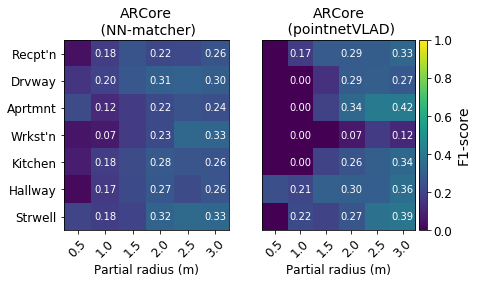

In [116]:
fig = plt.figure(figsize=(6.5,3.5))

with open("testing_results/pointnetvlad_arcore/" + "arcore_summary_results.pickle",'rb') as f:
    arcore_pv_results, arcore_pv_per_space_score, arcore_pv_perf_scores = pickle.load(f)
    
with open("testing_results/pointnetvlad_prod/" + "summary_results.pickle",'rb') as f:
    pointnetvlad_results, pointnetvlad_per_space_score, pointnetvlad_perf_scores = pickle.load(f)
    
with open("testing_results/partial/" + "summary_results_1000.pickle",'rb') as f:
    nn_results_partials, nn_per_space_score, nn_perf_scores = pickle.load(f)
    
with open("testing_results/nn_matcher_arcore/" + "summary_results.pickle",'rb') as f:
    arcore_results_partials, arcore_nn_per_space_score, arcore_nn_perf_scores = pickle.load(f)

#fig3 = plt.figure(constrained_layout=True)
#gs = fig3.add_gridspec(3, 3)
ax2 = fig.add_subplot(121)
ax3 = fig.add_subplot(122)
#fig.figsize(8,3.5)

im2 = ax2.imshow(
    arcore_nn_per_space_score[1:12:2,0].T,
    vmin=0.0, vmax=1.0, aspect='auto',
    cmap = plt.cm.viridis
)

for i, per_radius in enumerate(arcore_nn_per_space_score[3:12:4,0]):
    
    for j, value in enumerate(per_radius):
        
        color = 'white'
        
        if i == 0: color = 'white'

        ax2.text(
            i*2+1, j,
            ha="center", va="center",
            s = "{:.2f}".format(value),
            fontsize = 10,
            color = color
        )

ax2.set_title("ARCore\n (NN-matcher)", fontsize = 14)
ax2.set_xticks(np.arange(6))
ax2.set_xticklabels(arcore_nn_perf_scores[1:12:2,0], rotation=45, fontsize = 12)
ax2.set_xlabel("Partial radius (m)",fontsize = 12)
ax2.set_yticks(np.arange(len(contiguous_names)))
ax2.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);
#ax2.set_yticks([])
#ax2.set_yticklabels([])
#ax2.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);

im3 = ax3.imshow(
    arcore_pv_per_space_score[1:12:2,0].T,
    vmin=0.0, vmax=1.0, aspect='auto',
    cmap = plt.cm.viridis
)

for i, per_radius in enumerate(arcore_pv_per_space_score[3:12:4,0]):
    
    for j, value in enumerate(per_radius):
        
        color = 'white'
        
        if i == 0: color = 'white'

        ax3.text(
            i*2+1, j,
            ha="center", va="center",
            s = "{:.2f}".format(value),
            fontsize = 10,
            color = color
        )

ax3.set_title("ARCore\n (pointnetVLAD)", fontsize = 14)
ax3.set_xticks(np.arange(6))
ax3.set_xticklabels(arcore_pv_perf_scores[1:12:2,0], rotation=45, fontsize = 12)
ax3.set_xlabel("Partial radius (m)",fontsize = 12)
ax3.set_yticks([])
ax3.set_yticklabels([])
#ax2.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);

# Create divider for existing axes instance
divider3 = make_axes_locatable(ax3)
# Append axes to the right of ax3, with 20% width of ax3
cax3 = divider3.append_axes("right", size="5%", pad=0.05)

# Create colorbar in the appended axes
# Tick locations can be set with the kwarg `ticks`
# and the format of the ticklabels with kwarg `format`
cbar3 = plt.colorbar(im3, cax=cax3, ticks=np.arange(0.0,1.1,0.2), format="%.1f")
#cbar1.ax.set_ylabel("F1-score", fontsize = 14)

cbar3.ax.set_yticklabels(
    np.around(np.arange(0.0,1.1,0.2),decimals = 2),
#    np.concatenate((['≤ 0.4'],np.around(np.arange(0.5,1.1,0.1), decimals = 2))),
    fontsize = 12);
cbar3.ax.set_ylabel("F1-score", fontsize = 14)
"""
ax2.set_xticks(np.arange(0,6))
ax2.set_xticklabels(np.arange(0.25, 3.0, 0.5),fontsize = 14)
ax2.set_xlabel('Partial radius', fontsize = 14)
ax2.set_yticks(np.arange(0,7,1))
#plt.yticks(np.arange(0,7,1),contiguous_names_short,fontsize = 12)
ax2.set_yticklabels(contiguous_names_short,fontsize = 12)
#plt.yticklabels(
"""
#plt.xlabel('Partial radius', fontsize = 14)
#plt.xticks(np.arange(0,6),np.arange(0.25, 1.6, 0.25),fontsize = 14)
#plt.show()

plt.savefig('properties/arcore-f1-scores-annotated.pdf', format='pdf', dpi=300,bbox_inches = 'tight')
plt.savefig('properties/arcore-f1-scores-annotated.png', format='png', dpi=300,bbox_inches = 'tight')


In [107]:
np.arange(1,12,2)

array([ 1,  3,  5,  7,  9, 11])

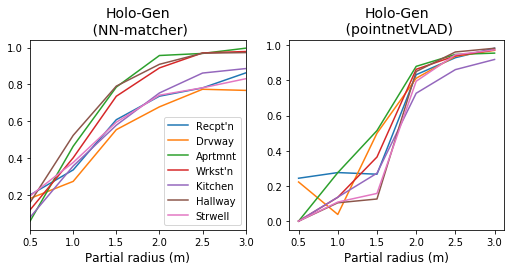

In [89]:
fig = plt.figure(figsize=(8.5,3.5))

#fig3 = plt.figure(constrained_layout=True)
#gs = fig3.add_gridspec(3, 3)
ax2 = fig.add_subplot(121)
ax3 = fig.add_subplot(122)
#fig.figsize(8,3.5)

for i, per_radius in enumerate(nn_per_space_score[1:12:2,0].T):
    
    ax2.plot(
        nn_perf_scores[1:12:2,0],
        per_radius,
        label = contiguous_names_short[i]
    )

ax2.set_title("Holo-Gen\n (NN-matcher)", fontsize = 14)
#ax2.set_xticks(np.arange(6))
ax2.set_xlim(0.5,3.0)
#ax2.set_xticklabels(nn_perf_scores[1:12:2,0], fontsize = 12)
ax2.set_xlabel("Partial radius (m)",fontsize = 12)
#ax2.set_yticks(np.arange(len(contiguous_names)))
#ax2.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);
#ax2.set_yticks([])
#ax2.set_yticklabels([])
#ax2.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);

for i, per_radius in enumerate(pointnetvlad_per_space_score[1:12:2,0].T):
    
    ax3.plot(
        pointnetvlad_perf_scores[1:12:2,0],
        per_radius,
        label = contiguous_names_short[i]
    )

ax3.set_title("Holo-Gen\n (pointnetVLAD)", fontsize = 14)
#ax3.set_xticks(np.arange(6))
ax2.set_xlim(0.5,3.0)
#ax3.set_xticklabels(pointnetvlad_perf_scores[1:12:2,0], rotation=45, fontsize = 12)
ax3.set_xlabel("Partial radius (m)",fontsize = 12)
#ax3.set_yticks([])
#ax3.set_yticklabels([])
#ax2.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);

ax2.legend()


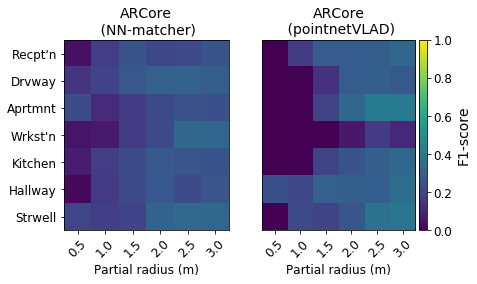

In [69]:
fig = plt.figure(figsize=(6.5,3.5))

with open("testing_results/pointnetvlad_arcore/" + "arcore_summary_results.pickle",'rb') as f:
    arcore_pv_results, arcore_pv_per_space_score, arcore_pv_perf_scores = pickle.load(f)
    
with open("testing_results/pointnetvlad_prod/" + "summary_results.pickle",'rb') as f:
    pointnetvlad_results, pointnetvlad_per_space_score, pointnetvlad_perf_scores = pickle.load(f)
    
with open("testing_results/partial/" + "summary_results.pickle",'rb') as f:
    nn_results_partials, nn_per_space_score, nn_perf_scores = pickle.load(f)
    
with open("testing_results/nn_matcher_arcore/" + "summary_results.pickle",'rb') as f:
    arcore_results_partials, arcore_nn_per_space_score, arcore_nn_perf_scores = pickle.load(f)

#fig3 = plt.figure(constrained_layout=True)
#gs = fig3.add_gridspec(3, 3)
ax2 = fig.add_subplot(121)
ax3 = fig.add_subplot(122)
#fig.figsize(8,3.5)

im2 = ax2.imshow(
    arcore_nn_per_space_score[1:12:2,0].T,
    vmin=0.0, vmax=1.0, 
    aspect='auto',
    cmap = plt.cm.viridis
)

ax2.set_title("ARCore\n (NN-matcher)", fontsize = 14)
ax2.set_xticks(np.arange(6))
ax2.set_xticklabels(arcore_nn_perf_scores[1:12:2,0], rotation=45, fontsize = 12)
ax2.set_xlabel("Partial radius (m)",fontsize = 12)
ax2.set_yticks(np.arange(len(contiguous_names)))
ax2.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);
#ax2.set_yticks([])
#ax2.set_yticklabels([])
#ax2.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);

im3 = ax3.imshow(
    arcore_pv_per_space_score[1:12:2,0].T,
    vmin=0.0, vmax=1.0, 
    aspect='auto',
    cmap = plt.cm.viridis
)

ax3.set_title("ARCore\n (pointnetVLAD)", fontsize = 14)
ax3.set_xticks(np.arange(6))
ax3.set_xticklabels(arcore_pv_perf_scores[1:12:2,0], rotation=45, fontsize = 12)
ax3.set_xlabel("Partial radius (m)",fontsize = 12)
ax3.set_yticks([])
ax3.set_yticklabels([])
#ax2.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);

# Create divider for existing axes instance
divider3 = make_axes_locatable(ax3)
# Append axes to the right of ax3, with 20% width of ax3
cax3 = divider3.append_axes("right", size="5%", pad=0.05)

# Create colorbar in the appended axes
# Tick locations can be set with the kwarg `ticks`
# and the format of the ticklabels with kwarg `format`
cbar3 = plt.colorbar(im3, cax=cax3, ticks=np.arange(0.0,1.1,0.2), format="%.1f")
#cbar1.ax.set_ylabel("F1-score", fontsize = 14)
cbar3.ax.set_yticklabels(
    np.around(np.arange(0.0,1.1,0.2),decimals = 2),
#    np.concatenate((np.around(np.arange(0.0,0.41,0.1), decimals = 2),['≥0.5'])),
    fontsize = 12
);
cbar3.ax.set_ylabel("F1-score", fontsize = 14)
"""
ax2.set_xticks(np.arange(0,6))
ax2.set_xticklabels(np.arange(0.25, 3.0, 0.5),fontsize = 14)
ax2.set_xlabel('Partial radius', fontsize = 14)
ax2.set_yticks(np.arange(0,7,1))
#plt.yticks(np.arange(0,7,1),contiguous_names_short,fontsize = 12)
ax2.set_yticklabels(contiguous_names_short,fontsize = 12)
#plt.yticklabels(
"""
#plt.xlabel('Partial radius', fontsize = 14)
#plt.xticks(np.arange(0,6),np.arange(0.25, 1.6, 0.25),fontsize = 14)
#plt.show()

plt.savefig('properties/arcore-f1-scores-no-label.pdf', format='pdf', dpi=300,bbox_inches = 'tight')
plt.savefig('properties/arcore-f1-scores-no-label.png', format='png', dpi=300,bbox_inches = 'tight')


Text(0.5, 1.0, 'NN-matcher')

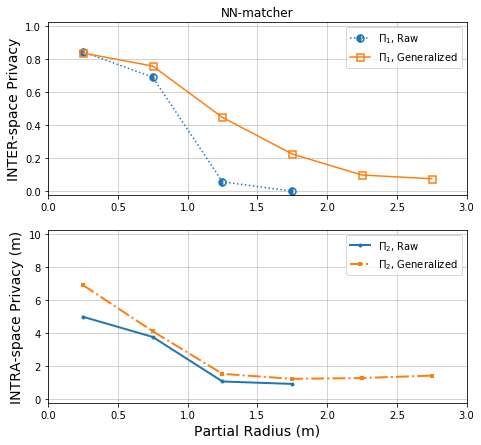

In [96]:
# Using privacy
fig=plt.figure(figsize=(7.5, 7))

with open('testing_results/partial/results_partials_nn_matcher.pickle', 'rb') as f:
    results_partials, _, _ = pickle.load(f)

RawNN = np.asarray(results_partials[0])
RansacNN = np.asarray(results_partials[1])
linewidth = 2.0
markersize = 2.0

ax2 = fig.add_subplot(212)#, sharex = ax1) 

ax2.grid(alpha = 0.7)
ax2.set_ylim(-0.25,10.25)
ax2.set_xlim(0,3)

ax2.set_ylabel("INTRA-space Privacy (m)", fontsize = 14);
ax2.set_xlabel("Partial Radius (m)", fontsize = 14);
#ax2.set_yticklabels(fontsize = 16)
#ax2.set_xticklabels(fontsize = 16)

#plt.minorticks_on()

ax2.plot(
    RawNN[:,0],
    RawNN[:,2], 
    linewidth = linewidth, 
    marker = 'o',fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "$\Pi_2$, Raw"
)
ax2.plot(
    RansacNN[:,0],
    RansacNN[:,2],
    '-.s',
    linewidth = linewidth,
    fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "$\Pi_2$, Generalized"
)

ax2.legend(loc = "upper right", ncol = 1, fontsize = 10);#, bbox_to_anchor=(1.1, 1.5));

ax1 = fig.add_subplot(211, sharex = ax2) 

ax1.grid(alpha = 0.7)
ax1.set_ylim(-0.025,1.025)
ax1.set_xlim(0,3.0)
ax1.set_ylabel("INTER-space Privacy", fontsize = 14);
#ax1.set_xlabel("Partial Radius", fontsize = 14);

markersize = 7
linewidth = 1.5

p1 = ax1.plot(
    RawNN[:,0],RawNN[:,1],
    ":o",
    linewidth = linewidth,fillstyle = 'left',
    mew = linewidth,markersize = markersize,
    label = "$\Pi_1$, Raw"
)
p2 = ax1.plot(
    RansacNN[:,0],
    RansacNN[:,1],
    "-s",
    linewidth = linewidth,
    fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "$\Pi_1$, Generalized"
)

ax1.legend(loc = "upper right", ncol = 1, fontsize = 10);# bbox_to_anchor=(1.1, 1.5));

plt.title("NN-matcher")

#plt.savefig('plots/one-time-partials-spaces.png', format='png', dpi=300,bbox_inches = 'tight')


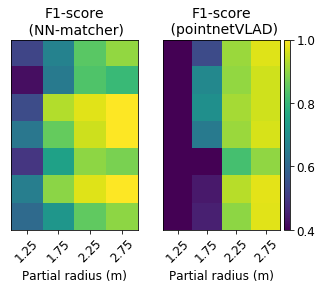

In [568]:
fig = plt.figure(figsize=(5,3.5))

#fig, (ax2, ax3) = #plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 1.2]})

#fig3 = plt.figure(constrained_layout=True)
#gs = fig3.add_gridspec(3, 3)
ax2 = fig.add_subplot(121)
ax3 = fig.add_subplot(122)
#fig.figsize(8,3.5)

im2 = ax2.imshow(
    per_space_score[2:,0].T,
    vmin=0.4, vmax=1.0, aspect='auto',
    cmap = plt.cm.viridis
)

ax2.set_title("F1-score\n (NN-matcher)", fontsize = 14)
ax2.set_xticks(np.arange(4))
ax2.set_xticklabels(np.arange(0.25, 3.0, 0.5)[2:], rotation=45, fontsize = 12)
ax2.set_xlabel("Partial radius (m)",fontsize = 12)
#ax2.set_yticks(np.arange(len(contiguous_names)))
#ax2.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);
ax2.set_yticks([])
ax2.set_yticklabels([])
#ax2.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);

im3 = ax3.imshow(
    pointnetvlad_per_space_score[4::2,0].T,
    vmin=0.4, vmax=1.0, aspect='auto',
    cmap = plt.cm.viridis
)

ax3.set_title("F1-score\n (pointnetVLAD)", fontsize = 14)
ax3.set_xticks(np.arange(4))
ax3.set_xticklabels(np.arange(1.25, 3.1, 0.5), rotation=45, fontsize = 12)
ax3.set_xlabel("Partial radius (m)",fontsize = 12)
ax3.set_yticks([])
ax3.set_yticklabels([])
#ax2.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);

# Create divider for existing axes instance
divider3 = make_axes_locatable(ax3)
# Append axes to the right of ax3, with 20% width of ax3
cax3 = divider3.append_axes("right", size="5%", pad=0.05)

# Create colorbar in the appended axes
# Tick locations can be set with the kwarg `ticks`
# and the format of the ticklabels with kwarg `format`
cbar3 = plt.colorbar(im3, cax=cax3, ticks=np.arange(0.4,1.1,0.2), format="%.2f")
#cbar1.ax.set_ylabel("F1-score", fontsize = 14)
cbar3.ax.set_yticklabels(np.around(np.arange(0.4,1.1,0.2), decimals = 2),fontsize = 12);

"""
ax2.set_xticks(np.arange(0,6))
ax2.set_xticklabels(np.arange(0.25, 3.0, 0.5),fontsize = 14)
ax2.set_xlabel('Partial radius', fontsize = 14)
ax2.set_yticks(np.arange(0,7,1))
#plt.yticks(np.arange(0,7,1),contiguous_names_short,fontsize = 12)
ax2.set_yticklabels(contiguous_names_short,fontsize = 12)
#plt.yticklabels(
"""
#plt.xlabel('Partial radius', fontsize = 14)
#plt.xticks(np.arange(0,6),np.arange(0.25, 1.6, 0.25),fontsize = 14)
#plt.show()
plt.savefig('properties/f1-scores-no-label-0.4.pdf', format='pdf', dpi=300,bbox_inches = 'tight')
plt.savefig('properties/f1-scores-no-label-0.4.png', format='png', dpi=300,bbox_inches = 'tight')


# Comparing distrbutions of local vector similarity per partial spaces vs inference success.

In [192]:
RESULTS_FOLDER="testing_results/pointnetvlad_prod/"
if not os.path.exists(RESULTS_FOLDER): os.mkdir(RESULTS_FOLDER)   
    
pickle_file = 'partial_results_updated_refs.pickle'

try:
    with open(RESULTS_FOLDER + pickle_file,'rb') as pickle_output:
        results_pickle = pickle.load(pickle_output)
except:
    print("No results.")
    
pointnetvlad_results = []
pointnetvlad_per_space_score = []
pointnetvlad_perf_scores= []

for radius, recall, intra_dist, test_recall in results_pickle:
    
    pointnetvlad_results.append([
        radius,
        recall[0],
        intra_dist[0]
    ])
    
    count_diff = 0

    errors_pool = []
    
    for m, n, top1_obj_cands in test_recall:
        
        if len(errors_pool) == 0:
            errors_pool = top1_obj_cands
        else:
            errors_pool = np.concatenate((errors_pool,top1_obj_cands), axis = 0)
            
    print(radius, len(test_recall), len(errors_pool))

0.25 2 1980
0.5 2 1996
0.75 2 1990
1.0 2 1998
1.25 2 1998
1.5 2 2000
1.75 2 2000
2.0 2 2000
2.25 2 2000
2.5 2 2000
2.75 2 2000
3.0 2 2000


In [91]:
        
    macro_score = f1_score(errors_pool[:,0],errors_pool[:,1],average='macro')    
    micro_score = f1_score(errors_pool[:,0],errors_pool[:,1],average='micro')
    mcc = matthews_corrcoef(errors_pool[:,0],errors_pool[:,1])
    ave_prec_score = precision_score(errors_pool[:,0],errors_pool[:,1],average='macro')
    prec_score = precision_score(errors_pool[:,0],errors_pool[:,1],average=None)
    ave_recl_score = recall_score(errors_pool[:,0],errors_pool[:,1],average='macro')
    recl_score = recall_score(errors_pool[:,0],errors_pool[:,1],average=None)
    
    pointnetvlad_per_space_score.append([
        f1_score(errors_pool[:,0],errors_pool[:,1],average=None),
        prec_score,
        recl_score
    ])
    
    pointnetvlad_perf_scores.append([
        radius,
        macro_score,
        micro_score,
        mcc
        #(np.sum(score_map) - np.trace(score_map))/np.sum(score_map)
    ])

    1 - count_diff/len(test_recall)
    
    
pointnetvlad_results = np.asarray(pointnetvlad_results)
pointnetvlad_per_space_score = np.asarray(pointnetvlad_per_space_score)
pointnetvlad_perf_scores = np.asarray(pointnetvlad_perf_scores)

with open("testing_results/pointnetvlad_prod/" + "summary_results.pickle",'wb') as f:
    pickle.dump([pointnetvlad_results, pointnetvlad_per_space_score, pointnetvlad_perf_scores],f)
    

/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [227]:
radius = 2.0

try:
    with bz2.BZ2File('testing_results/partial/ransac_{}_partial_scores_parallel_sample_points_2.pickle.bz2'.format(radius), 'r') as bz2_f:
        partial_scores_pool = pickle.load(bz2_f) 

except:
    print("Error getting scores for",radius)
    
partial_errors_pool = NN_matcher(partial_scores_pool)
correct_interspace_labels_idxs = np.where(partial_errors_pool[:,1]==0)[0]
intraspace_errors  = partial_errors_pool[correct_interspace_labels_idxs,2]

incorrect_interspace_labels_idxs = np.where(partial_errors_pool[:,1]==1)[0]


"""
            partial_errors.append([
                obj_meta[0],
                0,
                LA.norm(np.mean(best_ref_kps[:,:3], axis = 0) - obj_meta[2][:3]),
                np.argmax(weighted_scores)
            ])
"""

'\n            partial_errors.append([\n                obj_meta[0],\n                0,\n                LA.norm(np.mean(best_ref_kps[:,:3], axis = 0) - obj_meta[2][:3]),\n                np.argmax(weighted_scores)\n            ])\n'

In [ ]:
"""
            per_space_values.append([
                hist,
                CY,
                values,
                hist_all, 
                values_all,
                neighbor_size,
                len(pointCloud)
            ])
    
        norm_cdf_values.append([
            [obj_, object_name, original_vertex],
            per_space_values
        ])
        
        if len(norm_cdf_values) % 66 == 2:
            
            print("  ",radius,": Done with {}, in {:.3f} seconds.".format(
                len(norm_cdf_values),
                time.time()-t1
            ))
                
            t1 = time.time()
            
        with bz2.BZ2File('testing_results/partial/ransac_{}_partial_sim_hist.pickle.bz2'.format(radius), 'w') as bz2_f:
            pickle.dump(norm_cdf_values, bz2_f)
"""

In [226]:
nn_labels_partial_spaces = []

for i, [obj_meta, diff_ratios, diff_indexs, diff_scores, local_keypoint_matches] in enumerate(partial_scores_pool):

    #if i not in correct_interspace_labels_idxs: continue

    #if obj_meta[0] == 2 :
        
        nn_labels_partial_spaces.append([
            obj_meta[0],
            obj_meta[2][0],
            obj_meta[2][1],
            obj_meta[2][2],
            partial_errors_pool[i,-1]
        ])
        
nn_labels_partial_spaces = np.asarray(nn_labels_partial_spaces)


('Number of perfect matches', 1000)

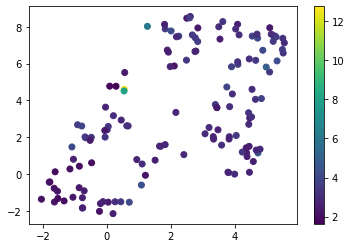

In [135]:
plt.scatter(
    x = per_sample_norm_cdf[:,0],
    y = per_sample_norm_cdf[:,2],
    c = per_sample_norm_cdf[:,5],
    #norm = True,
    #vmin = 0, vmax = 1.0,
    cmap = plt.cm.viridis
)
plt.colorbar()

nbrs = NearestNeighbors(n_neighbors=3, algorithm='kd_tree').fit(per_sample_high_norm[:,:4])
distances, indices = nbrs.kneighbors(nn_labels_partial_spaces[:,:4])
"Number of perfect matches",np.count_nonzero(distances[:,0] == 0)

In [292]:
with bz2.BZ2File('testing_results/partial/ransac_{}_partial_sim_hist.pickle.bz2'.format(2.0), 'r') as bz2_f:
    norm_cdf_values = pickle.load(bz2_f)
    
per_sample_high_norm = []

for [obj_, object_name, original_vertex], per_space_values in norm_cdf_values:
    
    #if obj_ != 2: continue
    
    norm_cdf_ratios = [
        obj_,
        original_vertex[0],
        original_vertex[1],
        original_vertex[2]
    ]
    
    for hist, CY, values, hist_all, values_all, neighbor_size, len__ in per_space_values:
        
        np.sum(hist*values[1:])/np.sum(hist)
        
        norm_cdf_ratios.append(
            #neighbor_size,
            np.sum(hist[95:])/np.sum(hist)
            #np.sum(hist_all[:80])/np.sum(hist_all[80:-1]),
            #np.sum(hist_all[80:-1])/np.sum(hist_all[:80]),
            #np.sum(hist*values[1:])/np.sum(hist)
            #np.sum(hist[50:])/np.sum(hist[:50]),
        )
        
    per_sample_high_norm.append(norm_cdf_ratios)
    
per_sample_high_norm = np.asarray(per_sample_high_norm)


In [405]:
#fig = plt.figure(figsize=(8,2))

radius = 2.0

try:
    with bz2.BZ2File('testing_results/partial/ransac_{}_partial_scores_parallel_sample_points_2.pickle.bz2'.format(radius), 'r') as bz2_f:
        partial_scores_pool = pickle.load(bz2_f) 

except:
    print("Error getting scores for",radius)
    
partial_errors_pool = NN_matcher(partial_scores_pool)
correct_interspace_labels_idxs = np.where(partial_errors_pool[:,1]==0)[0]
intraspace_errors  = partial_errors_pool[correct_interspace_labels_idxs,2]

incorrect_interspace_labels_idxs = np.where(partial_errors_pool[:,1]==1)[0]

/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:773: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


[ 100  400 1600]
Plot for radius 2.0 and neighborhood size 400


"\nplt.savefig(\n    'properties/correct_vs_incorrect_nn_holo_{}_{}.pdf'.format(radius,neighbor_sizes[neighborhood_index]),\n    format='pdf', dpi=300,bbox_inches = 'tight'\n)\n\nplt.savefig(\n    'properties/correct_vs_incorrect_nn_holo_{}_{}.png'.format(radius,neighbor_sizes[neighborhood_index]),\n    format='png', dpi=300,bbox_inches = 'tight'\n)\n"

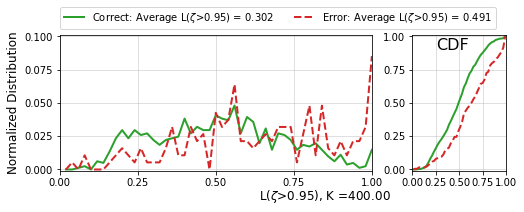

In [406]:
neighborhood_index = 1

neighbor_sizes = 100*2**np.arange(0,6,2)
print(neighbor_sizes)

width = 0.02

"""
            partial_errors.append([
                obj_meta[0],
                0,
                LA.norm(np.mean(best_ref_kps[:,:3], axis = 0) - obj_meta[2][:3]),
                np.argmax(weighted_scores)
            ])
"""

fig, (ax1, ax2) = plt.subplots(
    1, 2, gridspec_kw={'width_ratios': [1, 0.3]},
    figsize = (8,2.5)
)

lw = 2
ax1.grid(alpha = 0.5)
ax2.grid(alpha = 0.5)

ax1.set_xlim(0.0,1.0)
ax2.set_xlim(0.0,1.0)
ax1.set_xticks(np.arange(0.0,1.1,0.25))
ax2.set_xticks(np.arange(0.0,1.1,0.25))

ax1.set_ylim(-0.001,0.101)
ax2.set_ylim(-0.01,1.01)
ax1.set_yticks(np.arange(0.0,0.11,0.025))
ax2.set_yticks(np.arange(0.0,1.01,0.25))

ax1.set_ylabel("Normalized Distribution", fontsize = 12)
ax2.text(
    x = 0.25, y = 0.9,
    s = "CDF", 
    fontsize = 16)

ax1.set_xlabel(
    "L($\zeta$>0.95), K ={:.2f}".format(neighbor_sizes[neighborhood_index]),
    fontsize = 12
)
ax1.xaxis.set_label_coords(0.85, -0.125)

#ax2.set_xlabel("P($\zeta$>0.95)", fontsize = 12)

correct_hist, correct_values = np.histogram(
    per_sample_high_norm[correct_interspace_labels_idxs,neighborhood_index+3], 
    bins = np.arange(0,1.01,0.02)
)

correct_mean = np.mean(per_sample_high_norm[correct_interspace_labels_idxs,neighborhood_index+4])
correct_std = np.std(per_sample_high_norm[correct_interspace_labels_idxs,neighborhood_index+4])
incorrect_mean = np.mean(per_sample_high_norm[incorrect_interspace_labels_idxs,neighborhood_index+4])
incorrect_std = np.std(per_sample_high_norm[incorrect_interspace_labels_idxs,neighborhood_index+4])

incorrect_hist, incorrect_values = np.histogram(
    per_sample_high_norm[incorrect_interspace_labels_idxs,neighborhood_index+3], 
    bins = np.arange(0,1.01,width)
)

ax1.plot(
    correct_values[1:],
    correct_hist/np.sum(correct_hist),
    color = 'tab:green',
    lw = lw,
    label = 'Correct: Average L($\zeta$>0.95) = {:.3f}'.format(correct_mean)
)

ax1.plot(
    incorrect_values[1:],
    incorrect_hist/np.sum(incorrect_hist),
    "--",
    lw = lw,
    color = 'tab:red',
    label = 'Error: Average L($\zeta$>0.95) = {:.3f}'.format(incorrect_mean)
)

ax2.plot(
    correct_values[1:]-0.5*width,
    np.cumsum(correct_hist/np.sum(correct_hist)),#correct_hist/np.sum(correct_hist),
    lw = lw,
    color = 'tab:green',
    label = 'Correct'
)

ax2.plot(
    correct_values[1:]-0.5*width,
    np.cumsum(incorrect_hist/np.sum(incorrect_hist)),#correct_hist/np.sum(correct_hist),
    "--",
    lw = lw,
    color = 'tab:red',
    label = 'Incorrect'
)

ax1.legend(
    ncol = 2,
    fontsize = 10,
    bbox_to_anchor = (0.7, 1.125),
    loc = "center"
)

print('Plot for radius {:.1f} and neighborhood size {}'.format(radius,neighbor_sizes[neighborhood_index]))

"""
plt.savefig(
    'properties/correct_vs_incorrect_nn_holo_{}_{}.pdf'.format(radius,neighbor_sizes[neighborhood_index]),
    format='pdf', dpi=300,bbox_inches = 'tight'
)

plt.savefig(
    'properties/correct_vs_incorrect_nn_holo_{}_{}.png'.format(radius,neighbor_sizes[neighborhood_index]),
    format='png', dpi=300,bbox_inches = 'tight'
)
"""

[ 100  400 1600]
Plot for radius 2.0 and neighborhood size 400


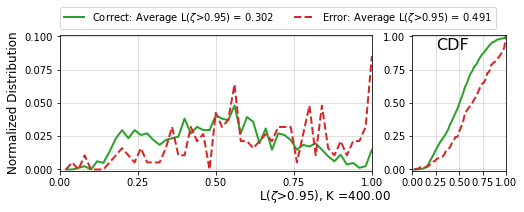

In [353]:
#correct_mean, incorrect_mean
plt.savefig(
    'properties/correct_vs_incorrect_nn_holo_{}_{}.pdf'.format(radius,neighbor_sizes[neighborhood_index]),
    format='pdf', dpi=300,bbox_inches = 'tight'
)

plt.savefig(
    'properties/correct_vs_incorrect_nn_holo_{}_{}.png'.format(radius,neighbor_sizes[neighborhood_index]),
    format='png', dpi=300,bbox_inches = 'tight'
)



[ 100  400 1600]
Bar Plot for radius 2.0 and neighborhood size 400


/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide


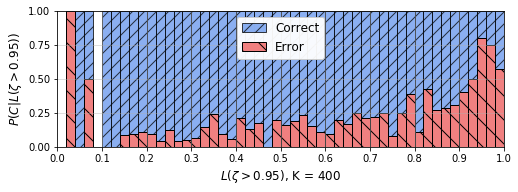

In [407]:
neighborhood_index = 1

neighbor_sizes = 100*2**np.arange(0,6,2)
print(neighbor_sizes)

width = 0.02

"""
            partial_errors.append([
                obj_meta[0],
                0,
                LA.norm(np.mean(best_ref_kps[:,:3], axis = 0) - obj_meta[2][:3]),
                np.argmax(weighted_scores)
            ])
"""

fig = plt.figure(figsize=(8,2.5))

ax1 = fig.add_subplot(111)

lw = 2
ax1.grid(alpha = 0.5)
#ax2.grid(alpha = 0.5)

ax1.set_xlim(-0.0,1.0)
ax1.set_xticks(np.arange(0.0,1.1,0.10))
#ax2.set_xlim(-0.0,1.0)
#ax2.set_xticks(np.arange(0.0,1.1,0.25))

#ax1.set_ylim(-0.01,0.11)
ax1.set_ylim(-0.0,1.0)
#ax2.set_ylim(-0.0,1.0)
ax1.set_yticks(np.arange(0.0,1.01,0.25))
#ax1.set_yticks(np.arange(0.0,0.11,0.025))
#ax2.set_yticks(np.arange(0.0,1.01,0.25))

ax1.set_ylabel("$P(C|L(\zeta > 0.95)$)", fontsize = 12)

ax1.set_xlabel(
    "$L(\zeta > 0.95)$, K = {}".format(neighbor_sizes[neighborhood_index]),
    fontsize = 12
)
#ax1.xaxis.set_label_coords(0.85, -0.125)

#ax2.set_xlabel("P($\zeta$>0.95)", fontsize = 12)

correct_hist, correct_values = np.histogram(
    per_sample_high_norm[correct_interspace_labels_idxs,neighborhood_index+3], 
    bins = np.arange(0,1.01,width)
)

correct_mean = np.mean(per_sample_high_norm[correct_interspace_labels_idxs,neighborhood_index+4])
incorrect_mean = np.mean(per_sample_high_norm[incorrect_interspace_labels_idxs,neighborhood_index+4])

incorrect_hist, incorrect_values = np.histogram(
    per_sample_high_norm[incorrect_interspace_labels_idxs,neighborhood_index+3], 
    bins = np.arange(0,1.01,width)
)

correct_hist_total = correct_hist/(correct_hist + incorrect_hist)
incorrect_hist_total = incorrect_hist/(correct_hist + incorrect_hist)

ax1.bar(
    correct_values[1:]-0.5*width,
    correct_hist_total+incorrect_hist_total,
    width = width,
    color = 'cornflowerblue',
    alpha = 0.75,
    edgecolor='black', hatch='//',
    label = 'Correct'#: Average $L(\zeta > 0.95)$ = {:.3f}'.format(correct_mean)
);

ax1.bar(
    correct_values[1:]-0.5*width,
    incorrect_hist_total,
    width = width,
    color = 'lightcoral',
    #alpha = 0.75,
    edgecolor='black', hatch='\\',
    label = 'Error'#: Average $L(\zeta > 0.95)$ = {:.3f}'.format(incorrect_mean)
)

ax1.legend(
    ncol = 1,
    fontsize = 12,
    #bbox_to_anchor = (0.5, 1.1),
    loc = "upper center",
    framealpha = 0.95
)

print('Bar Plot for radius {:.1f} and neighborhood size {}'.format(radius,neighbor_sizes[neighborhood_index]))

plt.savefig(
    'properties/per_z_correct_vs_incorrect_nn_holo_{}_{}.pdf'.format(radius,neighbor_sizes[neighborhood_index]),
    format='pdf', dpi=300,bbox_inches = 'tight'
)

plt.savefig(
    'properties/per_z_correct_vs_incorrect_nn_holo_{}_{}.png'.format(radius,neighbor_sizes[neighborhood_index]),
    format='png', dpi=300,bbox_inches = 'tight'
)


In [388]:
plt.savefig(
    'properties/per_z_correct_vs_incorrect_nn_holo_{}_{}.pdf'.format(radius,neighbor_sizes[neighborhood_index]),
    format='pdf', dpi=300,bbox_inches = 'tight'
)

plt.savefig(
    'properties/per_z_correct_vs_incorrect_nn_holo_{}_{}.png'.format(radius,neighbor_sizes[neighborhood_index]),
    format='png', dpi=300,bbox_inches = 'tight'
)

<Figure size 432x288 with 0 Axes>

[ 100  400 1600]
Plot for radius 2.0 and neighborhood size 400


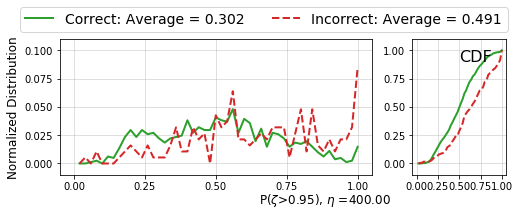

In [259]:
ax1.plot(
    correct_values[1:],
    correct_hist/np.sum(correct_hist),
    color = 'tab:green',
    lw = lw,
    label = 'Correct: Average = {:.3f}'.format(correct_mean)
)
ax1.plot(
    incorrect_values[1:],
    incorrect_hist/np.sum(incorrect_hist),
    "--",
    lw = lw,
    color = 'tab:red',
    label = 'Incorrect: Average = {:.3f}'.format(incorrect_mean)
)

ax2.plot(
    correct_values[1:],
    np.cumsum(correct_hist/np.sum(correct_hist)),#correct_hist/np.sum(correct_hist),
    lw = lw,
    color = 'tab:green',
    label = 'Correct'
)
ax2.plot(
    incorrect_values[1:],
    np.cumsum(incorrect_hist/np.sum(incorrect_hist)),#correct_hist/np.sum(correct_hist),
    "--",
    lw = lw,
    color = 'tab:red',
    label = 'Incorrect'
)

ax1.legend(
    ncol = 2,
    fontsize = 14,
    bbox_to_anchor = (-0.15, 1.0),
    loc = "lower left"
)

#correct_mean, incorrect_mean

print('Plot for radius {:.1f} and neighborhood size {}'.format(radius,neighbor_sizes[neighborhood_index]))

[ 100  400 1600]
Plot for radius 2.0 and neighborhood size 400


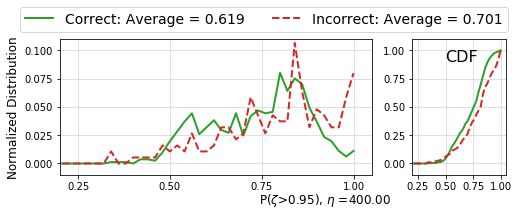

In [255]:

plt.savefig(
    'properties/correct_vs_incorrect_nn_holo_{}_{}.pdf'.format(radius,neighbor_sizes[neighborhood_index]),
    format='pdf', dpi=300,bbox_inches = 'tight'
)

plt.savefig(
    'properties/correct_vs_incorrect_nn_holo_{}_{}.png'.format(radius,neighbor_sizes[neighborhood_index]),
    format='png', dpi=300,bbox_inches = 'tight'
)


In [357]:
# Attempting it on pointnetvlad

In [368]:
with bz2.BZ2File('testing_results/partial/ransac_{}_partial_sim_hist.pickle.bz2'.format(2.0), 'r') as bz2_f:
    norm_cdf_values = pickle.load(bz2_f)
    
pv_per_sample_high_norm = []

for [obj_, object_name, original_vertex], per_space_values in norm_cdf_values:
    
    #if obj_ != 2: continue
    if object_name == "Reception-Data61-L5.obj":
        new_vX = original_vertex[0] + 50
        new_vZ = original_vertex[2] + 0
    elif object_name == "Driveway.obj":
        new_vX = original_vertex[0] - 25
        new_vZ = original_vertex[2] - 50
    elif object_name == "Apartment.obj":
        new_vX = original_vertex[0] + 25
        new_vZ = original_vertex[2] - 50
    elif object_name == "Workstations-Data61-L4.obj":
        new_vX = original_vertex[0] - 50
        new_vZ = original_vertex[2] + 0
    elif object_name == "Kitchen-Data61-L4.obj":
        new_vX = original_vertex[0] + 0
        new_vZ = original_vertex[2] + 0
    elif object_name == "HallWayToKitchen-Data61-L4.obj":
        new_vX = original_vertex[0] - 25
        new_vZ = original_vertex[2] + 50
    elif object_name == "StairWell-Data61-L4.obj":
        new_vX = original_vertex[0] + 25
        new_vZ = original_vertex[2] + 50
    else:
        print("Error:",obj_meta)
    
    norm_cdf_ratios = [
        obj_,
        new_vX,
        original_vertex[1],
        new_vZ
    ]
    
    for hist, CY, values, hist_all, values_all, neighbor_size, len__ in per_space_values:
        
        np.sum(hist*values[1:])/np.sum(hist)
        
        norm_cdf_ratios.append(
            #neighbor_size,
            np.sum(hist[95:])/np.sum(hist)
            #np.sum(hist_all[:80])/np.sum(hist_all[80:-1]),
            #np.sum(hist_all[80:-1])/np.sum(hist_all[:80]),
            #np.sum(hist*values[1:])/np.sum(hist)
            #np.sum(hist[50:])/np.sum(hist[:50]),
        )
        
    pv_per_sample_high_norm.append(norm_cdf_ratios)
    
pv_per_sample_high_norm = np.asarray(pv_per_sample_high_norm)


In [408]:
#fig = plt.figure(figsize=(8,2))

radius = 2.0

RESULTS_FOLDER="testing_results/pointnetvlad_prod_2/"
if not os.path.exists(RESULTS_FOLDER): os.mkdir(RESULTS_FOLDER)   
    
pickle_file = 'partial_results_updated_refs_2_0.5.pickle'

try:
    with open(RESULTS_FOLDER + pickle_file,'rb') as pickle_output:
        results_pickle = pickle.load(pickle_output)
except:
    print("No results.")

errors_pool = []

for radius, recall, intra_dist, test_recall in results_pickle:
    
    if radius != 2.0: continue
    
    for m, n, top1_obj_cands in test_recall:
        
        """
        if len(errors_pool) == 0:
            errors_pool = top1_obj_cands
        else:
            errors_pool = np.concatenate((errors_pool,top1_obj_cands), axis = 0)
        """
        
        for original_vertex, orig_label, cand_label in top1_obj_cands:
            
            #print(radius, m ,n, original_vertex, orig_label, cand_label)

            per_obj_label = []
            per_obj_label.append(orig_label)
            per_obj_label.append(cand_label)
            per_obj_label.append(original_vertex[0])
            per_obj_label.append(original_vertex[1])
            per_obj_label.append(original_vertex[2])
            errors_pool.append(per_obj_label)
            
        #print("  ",m,n,len(top1_obj_cands),len(errors_pool))
        
    break
    
pv_partial_errors_pool = np.asarray(errors_pool)
    
pv_correct_interspace_labels_idxs = np.where(pv_partial_errors_pool[:,1]==pv_partial_errors_pool[:,0])[0]

pv_incorrect_interspace_labels_idxs = np.where(pv_partial_errors_pool[:,1]!=pv_partial_errors_pool[:,0])[0]

pv_partial_errors_pool.shape, pv_correct_interspace_labels_idxs.shape, pv_incorrect_interspace_labels_idxs.shape

((2000, 5), (1644,), (356,))

In [363]:
pv_partial_errors_pool[:,0].shape

(2000,)

Number of perfect matches 0


(array([750., 102.,   0.,   0.,   0.,  82., 208., 480., 256., 122.]),
 array([ 0.19924807,  6.77533558, 13.35142309, 19.9275106 , 26.50359811,
        33.07968562, 39.65577313, 46.23186064, 52.80794814, 59.38403565,
        65.96012316]),
 <a list of 10 Patch objects>)

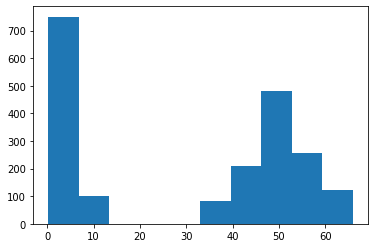

In [370]:
nbrs = NearestNeighbors(n_neighbors=3, algorithm='kd_tree').fit(pv_per_sample_high_norm[:,:4])
distances, indices = nbrs.kneighbors(
    np.concatenate((pv_partial_errors_pool[:,0,np.newaxis],pv_partial_errors_pool[:,-3:]), axis = 1)
)
print("Number of perfect matches",np.count_nonzero(distances[:,0] == 0))
plt.hist(distances[:,0])

In [372]:
pv_correct_interspace_labels_idxs % 1000

array([  0,   1,   2, ..., 996, 998, 999])

[ 100  400 1600]
Plot for radius 2.0 and neighborhood size 400


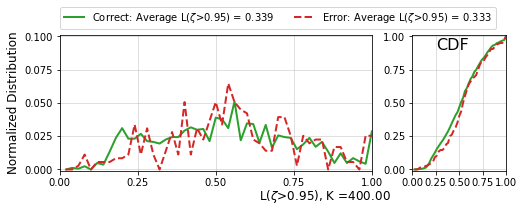

In [409]:
neighborhood_index = 1

neighbor_sizes = 100*2**np.arange(0,6,2)
print(neighbor_sizes)

width = 0.02

"""
            partial_errors.append([
                obj_meta[0],
                0,
                LA.norm(np.mean(best_ref_kps[:,:3], axis = 0) - obj_meta[2][:3]),
                np.argmax(weighted_scores)
            ])
"""

fig, (ax1, ax2) = plt.subplots(
    1, 2, gridspec_kw={'width_ratios': [1, 0.3]},
    figsize = (8,2.5)
)

lw = 2
ax1.grid(alpha = 0.5)
ax2.grid(alpha = 0.5)

ax1.set_xlim(0.0,1.0)
ax2.set_xlim(0.0,1.0)
ax1.set_xticks(np.arange(0.0,1.1,0.25))
ax2.set_xticks(np.arange(0.0,1.1,0.25))

ax1.set_ylim(-0.001,0.101)
ax2.set_ylim(-0.01,1.01)
ax1.set_yticks(np.arange(0.0,0.11,0.025))
ax2.set_yticks(np.arange(0.0,1.01,0.25))

ax1.set_ylabel("Normalized Distribution", fontsize = 12)
ax2.text(
    x = 0.25, y = 0.9,
    s = "CDF", 
    fontsize = 16)

ax1.set_xlabel(
    "L($\zeta$>0.95), K ={:.2f}".format(neighbor_sizes[neighborhood_index]),
    fontsize = 12
)
ax1.xaxis.set_label_coords(0.85, -0.125)

#ax2.set_xlabel("P($\zeta$>0.95)", fontsize = 12)

correct_hist, correct_values = np.histogram(
    per_sample_high_norm[pv_correct_interspace_labels_idxs%1000,neighborhood_index+3], 
    bins = np.arange(0,1.01,width)
)

correct_mean = np.mean(per_sample_high_norm[pv_correct_interspace_labels_idxs%1000,neighborhood_index+4])
incorrect_mean = np.mean(per_sample_high_norm[pv_incorrect_interspace_labels_idxs%1000,neighborhood_index+4])

incorrect_hist, incorrect_values = np.histogram(
    per_sample_high_norm[pv_incorrect_interspace_labels_idxs%1000,neighborhood_index+3], 
    bins = np.arange(0,1.01,width)
)

ax1.plot(
    correct_values[1:],
    correct_hist/np.sum(correct_hist),
    color = 'tab:green',
    lw = lw,
    label = 'Correct: Average L($\zeta$>0.95) = {:.3f}'.format(correct_mean)
)
ax1.plot(
    incorrect_values[1:],
    incorrect_hist/np.sum(incorrect_hist),
    "--",
    lw = lw,
    color = 'tab:red',
    label = 'Error: Average L($\zeta$>0.95) = {:.3f}'.format(incorrect_mean)
)

ax2.plot(
    correct_values[1:],
    np.cumsum(correct_hist/np.sum(correct_hist)),#correct_hist/np.sum(correct_hist),
    lw = lw,
    color = 'tab:green',
    label = 'Correct'
)
ax2.plot(
    incorrect_values[1:],
    np.cumsum(incorrect_hist/np.sum(incorrect_hist)),#correct_hist/np.sum(correct_hist),
    "--",
    lw = lw,
    color = 'tab:red',
    label = 'Incorrect'
)

ax1.legend(
    ncol = 2,
    fontsize = 10,
    bbox_to_anchor = (0.7, 1.125),
    loc = "center"
)

print('Plot for radius {:.1f} and neighborhood size {}'.format(radius,neighbor_sizes[neighborhood_index]))

plt.savefig(
    'properties/correct_vs_incorrect_pv_holo_{}_{}.pdf'.format(radius,neighbor_sizes[neighborhood_index]),
    format='pdf', dpi=300,bbox_inches = 'tight'
)

plt.savefig(
    'properties/correct_vs_incorrect_pv_holo_{}_{}.png'.format(radius,neighbor_sizes[neighborhood_index]),
    format='png', dpi=300,bbox_inches = 'tight'
)


[ 100  400 1600]
Plot for radius 2.0 and neighborhood size 400


/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


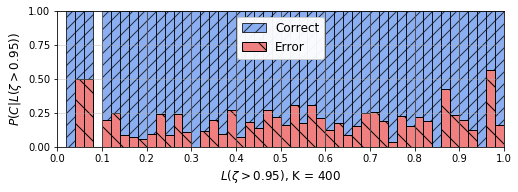

In [410]:
neighborhood_index = 1

neighbor_sizes = 100*2**np.arange(0,6,2)
print(neighbor_sizes)

"""
            partial_errors.append([
                obj_meta[0],
                0,
                LA.norm(np.mean(best_ref_kps[:,:3], axis = 0) - obj_meta[2][:3]),
                np.argmax(weighted_scores)
            ])
"""

fig = plt.figure(figsize=(8,2.5))

ax1 = fig.add_subplot(111)

lw = 2
ax1.grid(alpha = 0.5)
#ax2.grid(alpha = 0.5)

ax1.set_xlim(-0.0,1.0)
ax1.set_xticks(np.arange(0.0,1.1,0.10))
#ax2.set_xlim(-0.0,1.0)
#ax2.set_xticks(np.arange(0.0,1.1,0.25))

#ax1.set_ylim(-0.01,0.11)
ax1.set_ylim(-0.0,1.0)
#ax2.set_ylim(-0.0,1.0)
ax1.set_yticks(np.arange(0.0,1.01,0.25))
#ax1.set_yticks(np.arange(0.0,0.11,0.025))
#ax2.set_yticks(np.arange(0.0,1.01,0.25))

ax1.set_ylabel("$P(C|L(\zeta > 0.95)$)", fontsize = 12)

ax1.set_xlabel(
    "$L(\zeta > 0.95)$, K = {}".format(neighbor_sizes[neighborhood_index]),
    fontsize = 12
)

correct_hist_total = correct_hist/(correct_hist + incorrect_hist)
incorrect_hist_total = incorrect_hist/(correct_hist + incorrect_hist)

ax1.bar(
    correct_values[1:]-0.5*width,
    correct_hist_total+incorrect_hist_total,
    width = 0.02,
    color = 'cornflowerblue',
    alpha = 0.75,
    edgecolor='black', hatch='//',
    label = 'Correct'#: Average $L(\zeta > 0.95)$ = {:.3f}'.format(correct_mean)
);

ax1.bar(
    correct_values[1:]-0.5*width,
    incorrect_hist_total,
    width = 0.02,
    color = 'lightcoral',
    #alpha = 0.75,
    edgecolor='black', hatch='\\',
    label = 'Error'#: Average $L(\zeta > 0.95)$ = {:.3f}'.format(incorrect_mean)
)

#"""
ax1.legend(
    ncol = 1,
    fontsize = 12,
    #bbox_to_anchor = (0.5, 1.1),
    loc = "upper center",
    framealpha = 0.95
)
#"""

print('Plot for radius {:.1f} and neighborhood size {}'.format(radius,neighbor_sizes[neighborhood_index]))

plt.savefig(
    'properties/per_z_correct_vs_incorrect_pv_holo_{}_{}.pdf'.format(radius,neighbor_sizes[neighborhood_index]),
    format='pdf', dpi=300,bbox_inches = 'tight'
)

plt.savefig(
    'properties/per_z_correct_vs_incorrect_pv_holo_{}_{}.png'.format(radius,neighbor_sizes[neighborhood_index]),
    format='png', dpi=300,bbox_inches = 'tight'
)


[ 100  400 1600]


/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


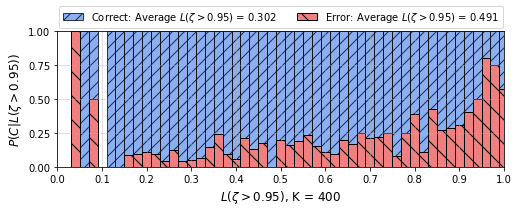

In [ ]:
#correct_mean, incorrect_mean
plt.savefig(
    'properties/correct_vs_incorrect_nn_holo_{}_{}.pdf'.format(radius,neighbor_sizes[neighborhood_index]),
    format='pdf', dpi=300,bbox_inches = 'tight'
)

plt.savefig(
    'properties/correct_vs_incorrect_nn_holo_{}_{}.png'.format(radius,neighbor_sizes[neighborhood_index]),
    format='png', dpi=300,bbox_inches = 'tight'
)

print('Plot for radius {:.1f} and neighborhood size {}'.format(radius,neighbor_sizes[neighborhood_index]))

In [ ]:
#ARCore

In [285]:
with open("testing_results/nn_matcher_arcore/{}_partial_sim_hist.pickle".format(2.0), 'rb') as f:
    norm_cdf_values = pickle.load(f)
    
arcore_per_sample_high_norm = []

for [obj_, object_name, original_vertex], per_space_values in norm_cdf_values:
    
    #if obj_ != 2: continue
    
    norm_cdf_ratios = [
        obj_,
        original_vertex[0],
        original_vertex[1],
        original_vertex[2]
    ]
    
    for hist, CY, values, hist_all, values_all, neighbor_size, len__ in per_space_values:
        
        np.sum(hist*values[1:])/np.sum(hist)
        
        norm_cdf_ratios.append(
            #neighbor_size,
            np.sum(hist_all[95:])/np.sum(hist_all)
            #np.sum(hist_all[:80])/np.sum(hist_all[80:-1]),
            #np.sum(hist_all[80:-1])/np.sum(hist_all[:80]),
            #np.sum(hist*values[1:])/np.sum(hist)
            #np.sum(hist[50:])/np.sum(hist[:50]),
        )
        
    arcore_per_sample_high_norm.append(norm_cdf_ratios)
    
arcore_per_sample_high_norm = np.asarray(arcore_per_sample_high_norm)


[ 100  400 1600]
Plot for radius 2.0 and neighborhood size 400


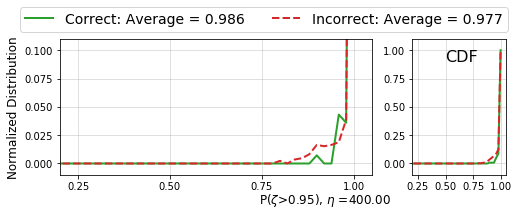

In [288]:
neighborhood_index = 1

neighbor_sizes = 100*2**np.arange(0,6,2)
print(neighbor_sizes)

"""
            partial_errors.append([
                obj_meta[0],
                0,
                LA.norm(np.mean(best_ref_kps[:,:3], axis = 0) - obj_meta[2][:3]),
                np.argmax(weighted_scores)
            ])
"""

fig, (ax1, ax2) = plt.subplots(
    1, 2, gridspec_kw={'width_ratios': [1, 0.3]},
    figsize = (8,2.5)
)

lw = 2
ax1.grid(alpha = 0.5)
ax2.grid(alpha = 0.5)

ax1.set_xlim(0.20,1.05)
ax2.set_xlim(0.20,1.05)
ax1.set_xticks(np.arange(0.25,1.1,0.25))
ax2.set_xticks(np.arange(0.25,1.1,0.25))

ax1.set_ylim(-0.01,0.11)
ax2.set_ylim(-0.1,1.1)
ax1.set_yticks(np.arange(0.0,0.11,0.025))
ax2.set_yticks(np.arange(0.0,1.01,0.25))

ax1.set_ylabel("Normalized Distribution", fontsize = 12)
ax2.text(
    x = 0.5, y = 0.9,
    s = "CDF", 
    fontsize = 16)

ax1.set_xlabel(
    "P($\zeta$>0.95), $\eta$ ={:.2f}".format(neighbor_sizes[neighborhood_index]),
    fontsize = 12
)
ax1.xaxis.set_label_coords(0.85, -0.125)

#ax2.set_xlabel("P($\zeta$>0.95)", fontsize = 12)

correct_hist, correct_values = np.histogram(
    arcore_per_sample_high_norm[arcore_correct_interspace_labels_idxs,neighborhood_index+3], 
    bins = np.arange(0,1.01,0.02)
)

incorrect_hist, incorrect_values = np.histogram(
    arcore_per_sample_high_norm[arcore_incorrect_interspace_labels_idxs,neighborhood_index+3], 
    bins = np.arange(0,1.01,0.02)
)

correct_mean = np.mean(arcore_per_sample_high_norm[correct_interspace_labels_idxs,neighborhood_index+4])
incorrect_mean = np.mean(arcore_per_sample_high_norm[incorrect_interspace_labels_idxs,neighborhood_index+4])


ax1.plot(
    correct_values[1:],
    correct_hist/np.sum(correct_hist),
    color = 'tab:green',
    lw = lw,
    label = 'Correct: Average = {:.3f}'.format(correct_mean)
)
ax1.plot(
    incorrect_values[1:],
    incorrect_hist/np.sum(incorrect_hist),
    "--",
    lw = lw,
    color = 'tab:red',
    label = 'Incorrect: Average = {:.3f}'.format(incorrect_mean)
)

ax2.plot(
    correct_values[1:],
    np.cumsum(correct_hist/np.sum(correct_hist)),#correct_hist/np.sum(correct_hist),
    lw = lw,
    color = 'tab:green',
    label = 'Correct'
)
ax2.plot(
    incorrect_values[1:],
    np.cumsum(incorrect_hist/np.sum(incorrect_hist)),#correct_hist/np.sum(correct_hist),
    "--",
    lw = lw,
    color = 'tab:red',
    label = 'Incorrect'
)

ax1.legend(
    ncol = 2,
    fontsize = 14,
    bbox_to_anchor = (-0.15, 1.0),
    loc = "lower left"
)

#correct_mean, incorrect_mean

plt.savefig(
    'properties/correct_vs_incorrect_nn_arcore_{}_{}.pdf'.format(radius,neighbor_sizes[neighborhood_index]),
    format='pdf', dpi=300,bbox_inches = 'tight'
)

plt.savefig(
    'properties/correct_vs_incorrect_nn_arcore_{}_{}.png'.format(radius,neighbor_sizes[neighborhood_index]),
    format='png', dpi=300,bbox_inches = 'tight'
)

print('Plot for radius {:.1f} and neighborhood size {}'.format(radius,neighbor_sizes[neighborhood_index]))

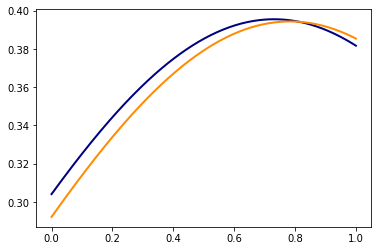

In [179]:
from distutils.version import LooseVersion
from scipy.stats import norm
from sklearn.neighbors import KernelDensity

correct_est = per_sample_high_norm[correct_interspace_labels_idxs,4,np.newaxis]

incorrect_est = per_sample_high_norm[incorrect_interspace_labels_idxs,4,np.newaxis]

# Gaussian KDE

"""
kde = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(X)
log_dens = kde.score_samples(X_plot)
ax[1, 1].fill(X_plot[:, 0], np.exp(log_dens), fc='#AAAAFF')
ax[1, 1].text(-3.5, 0.31, "Gaussian Kernel Density")
"""
bins = np.linspace(0,1,200)[:, np.newaxis]

c_kde = KernelDensity(kernel='gaussian', bandwidth=1.0).fit(correct_est)

log_dens = c_kde.score_samples(bins)

plt.plot(
    bins[:, 0], 
    np.exp(log_dens), 
    color='navy',
    lw=2,
    linestyle='-', 
    label="correct"
)

ic_kde = KernelDensity(kernel='gaussian', bandwidth=1.0).fit(incorrect_est)

log_dens = ic_kde.score_samples(bins)

plt.plot(
    bins[:, 0], 
    np.exp(log_dens), 
    color='darkorange',
    lw=2,
    linestyle='-', 
    label="incorrect"
)

In [168]:
bins.shape, correct_est.shape, incorrect_est.shape

((100, 1), (812, 1), (188, 1))

188

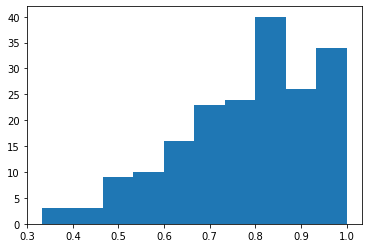

In [141]:
incorrect_interspace_labels_idxs = np.where(partial_errors_pool[:,1]==1)[0]

plt.hist(per_sample_high_norm[incorrect_interspace_labels_idxs,4])

len(incorrect_interspace_labels_idxs)

((133, 6), (133, 4))

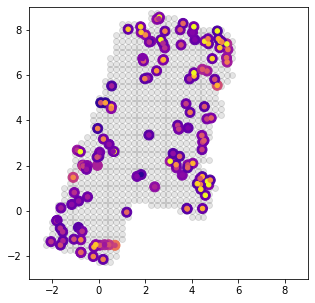

In [205]:

fig = plt.figure(figsize=(5,5))

obj__, point_cloud, triangles = new_contiguous_point_collection[2]

obj__, point_cloud.shape, triangles.shape

floor_pointcloud = 0.25*100*np.around((0.01/0.25)*point_cloud[:,[0,2]],decimals=2)
unq_floor_pointcloud = np.unique(floor_pointcloud,axis = 0)

X = floor_pointcloud[:,0]
Z = floor_pointcloud[:,1]

plt.xlim(-3,9)
plt.ylim(-3,9)

plt.scatter(
    unq_floor_pointcloud[:,0],
    unq_floor_pointcloud[:,1],
    color = 'black',
    alpha = 0.1
)

plt.scatter(
    per_sample_norm_cdf[indices[:,0],0],
    per_sample_norm_cdf[indices[:,0],2],
    c = per_sample_norm_cdf[indices[:,0],5],
    s = 100.0,
    #norm = True,
    vmin = 0, vmax = 2.0,
    cmap = plt.cm.plasma
)

plt.scatter(
    x = good_spaces[:,0],
    y = good_spaces[:,2],
    c = good_spaces[:,3],
    s = 20.0,
    #norm = True,
    vmin = 0, vmax = 2.0,
    cmap = plt.cm.plasma
)

#plt.colorbar()
per_sample_norm_cdf[indices[:,0]].shape, good_spaces.shape

((133, 6), (133, 4))

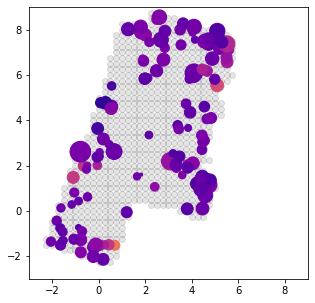

In [206]:

fig = plt.figure(figsize=(5,5))

obj__, point_cloud, triangles = new_contiguous_point_collection[2]

obj__, point_cloud.shape, triangles.shape

floor_pointcloud = 0.25*100*np.around((0.01/0.25)*point_cloud[:,[0,2]],decimals=2)
unq_floor_pointcloud = np.unique(floor_pointcloud,axis = 0)

X = floor_pointcloud[:,0]
Z = floor_pointcloud[:,1]

plt.xlim(-3,9)
plt.ylim(-3,9)

plt.scatter(
    unq_floor_pointcloud[:,0],
    unq_floor_pointcloud[:,1],
    color = 'black',
    alpha = 0.1
)

plt.scatter(
    per_sample_norm_cdf[indices[:,0],0],
    per_sample_norm_cdf[indices[:,0],2],
    c = per_sample_norm_cdf[indices[:,0],5],
    s =  good_spaces[:,3]*100,
    #norm = True,
    vmin = 0, vmax = 2.0,
    cmap = plt.cm.plasma
)

#plt.colorbar()
per_sample_norm_cdf[indices[:,0]].shape, good_spaces.shape

array([[ 1.        , -0.09740766],
       [-0.09740766,  1.        ]])

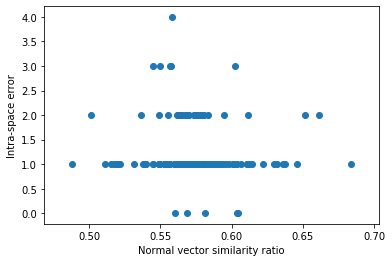

In [30]:
plt.scatter(
    per_sample_norm_cdf[indices[:,0],5],
    np.around(good_spaces[:,3], decimals = 0),
)
plt.ylabel("Intra-space error")
plt.xlabel("Normal vector similarity ratio")

np.corrcoef(
    per_sample_norm_cdf[indices[:,0],5],
    good_spaces[:,3]
)

array([[1.        , 0.16784513],
       [0.16784513, 1.        ]])

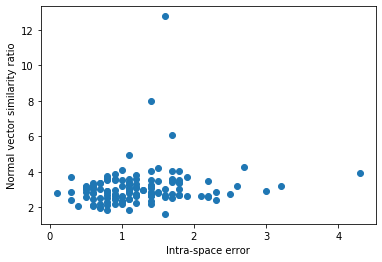

In [35]:
plt.scatter(
    np.around(good_spaces[:,3], decimals = 1),
    per_sample_norm_cdf[indices[:,0],5],
)
plt.xlabel("Intra-space error")
plt.ylabel("Normal vector similarity ratio")

np.corrcoef(
    per_sample_norm_cdf[indices[:,0],5],
    good_spaces[:,3]
)

(array([ 7., 38., 37., 32.,  8.,  6.,  2.,  2.,  0.,  1.]),
 array([0.09388551, 0.51053057, 0.92717563, 1.3438207 , 1.76046576,
        2.17711082, 2.59375588, 3.01040094, 3.427046  , 3.84369107,
        4.26033613]),
 <a list of 10 Patch objects>)

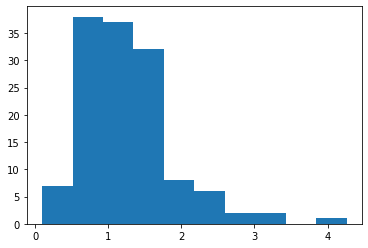

In [28]:
plt.hist(good_spaces[:,3])

In [209]:
with open('sample_points.pickle','rb') as f:
    sample_points = pickle.load(f)
    
neighbor_sizes = 100*2**np.arange(0,5,2)

radius_lrange = 4.0*2**np.arange(0,1)

len(sample_points), neighbor_sizes, radius_lrange

(1000, array([ 100,  400, 1600]), array([4.]))

In [108]:
for radius in radius_lrange:
    
    t0 = time.time()
    t1 = t0
    
    norm_cdf_values = []
    
    print("radius =",radius)
    
    for obj_, object_name, original_vertex in sample_points:
        
        pointCloud = []
        
        try:
            trial = np.random.randint(5)
            
            with open("../ransac_pc/ransac_point_collection_{}.pickle".format(trial),'rb') as f:
                ransac_trial_point_collection = pickle.load(f)

            object_, pointCloud_, tri_ = ransac_trial_point_collection[int(obj_)]
            
            ransac_ 
            
        if len(pointCloud) == 0: continue
            
        per_space_values = []
            
        for neighbor_size in neighbor_sizes:

            t0 = time.time()

            nbrs = NearestNeighbors(n_neighbors=min(neighbor_size,len(pointCloud)), algorithm='kd_tree').fit(pointCloud[:,:3])
            distances, indices = nbrs.kneighbors(pointCloud[:,:3])

            try:
                nearby_normals = pointCloud[indices,3:6]
                refrnc_normals = np.reshape(np.repeat(pointCloud[:,3:6],min(neighbor_size,len(pointCloud)),axis=0),nearby_normals.shape)

                normal_product = np.sum(np.multiply(refrnc_normals,nearby_normals),axis=2)

                #print(nearby_normals.shape, refrnc_normals.shape, normal_product.shape)
            except Exception as e1:
                print("Error while getting normals,", e1)

            color = np.mean(np.abs(normal_product))
            hist, values = np.histogram(np.mean(np.abs(normal_product),axis = 1), bins = np.arange(0,1.01,0.01))
            CY = np.cumsum(hist/np.sum(hist))

            per_space_values.append([
                hist,
                CY,
                values,
                np.trapz(CY, values[1:]),
                neighbor_size,
                len(pointCloud)
            ])
    
        norm_cdf_values.append([
            [obj_, object_name, original_vertex],
            per_space_values
        ])
        
        if len(norm_cdf_values) % 66 == 2:
            
            print("  ",radius,": Done with {}, in {:.3f} seconds.".format(
                len(norm_cdf_values),
                time.time()-t1
            ))
                
            t1 = time.time()
            
        with bz2.BZ2File('testing_results/partial/ransac_{}_partial_sim_hist.pickle.bz2'.format(radius), 'w') as bz2_f:
            pickle.dump(norm_cdf_values, bz2_f)

    print(radius," Total Time to compute similarities {:.3f} seconds.".format(time.time()-t0))
    

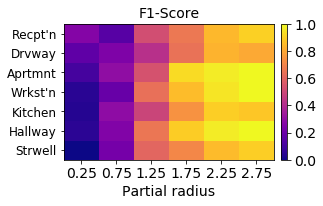

In [93]:
fig=plt.figure(figsize=(4,2.5))

ax1 = fig.add_subplot(1,1,1)

im1 = ax1.imshow(
    per_space_score[:,0].T,
    vmin=0, vmax=1.0, aspect='auto',
    cmap = plt.cm.viridis
)

# Create divider for existing axes instance
divider1 = make_axes_locatable(ax1)
# Append axes to the right of ax3, with 20% width of ax3
cax1 = divider1.append_axes("right", size="3%", pad=0.1)

# Create colorbar in the appended axes
# Tick locations can be set with the kwarg `ticks`
# and the format of the ticklabels with kwarg `format`
cbar1 = plt.colorbar(im1, cax=cax1, ticks=np.arange(0,1.6,0.2), format="%.2f")
#cbar1.ax.set_ylabel("F1-score", fontsize = 14)
cbar1.ax.set_yticklabels(np.arange(0,1.6,0.2, dtype = np.float32),fontsize = 14)

#cbar = plt.colorbar(ticks = np.arange(0,1.1,0.2))
#cbar.ax.set_ylabel("F1-score", fontsize = 14)
#cbar.ax.set_yticklabels(np.arange(0,1.1,0.2, dtype = np.float32),fontsize = 14)

ax1.set_title('F1-Score', fontsize = 14)
ax1.set_xticks(np.arange(0,6))
ax1.set_xticklabels(np.arange(0.25, 3.0, 0.5),fontsize = 14)
ax1.set_xlabel('Partial radius', fontsize = 14)
ax1.set_yticks(np.arange(0,7,1))
#plt.yticks(np.arange(0,7,1),contiguous_names_short,fontsize = 12)
ax1.set_yticklabels(contiguous_names_short,fontsize = 12)
#plt.yticklabels(

#plt.xlabel('Partial radius', fontsize = 14)
#plt.xticks(np.arange(0,6),np.arange(0.25, 1.6, 0.25),fontsize = 14)
plt.show()


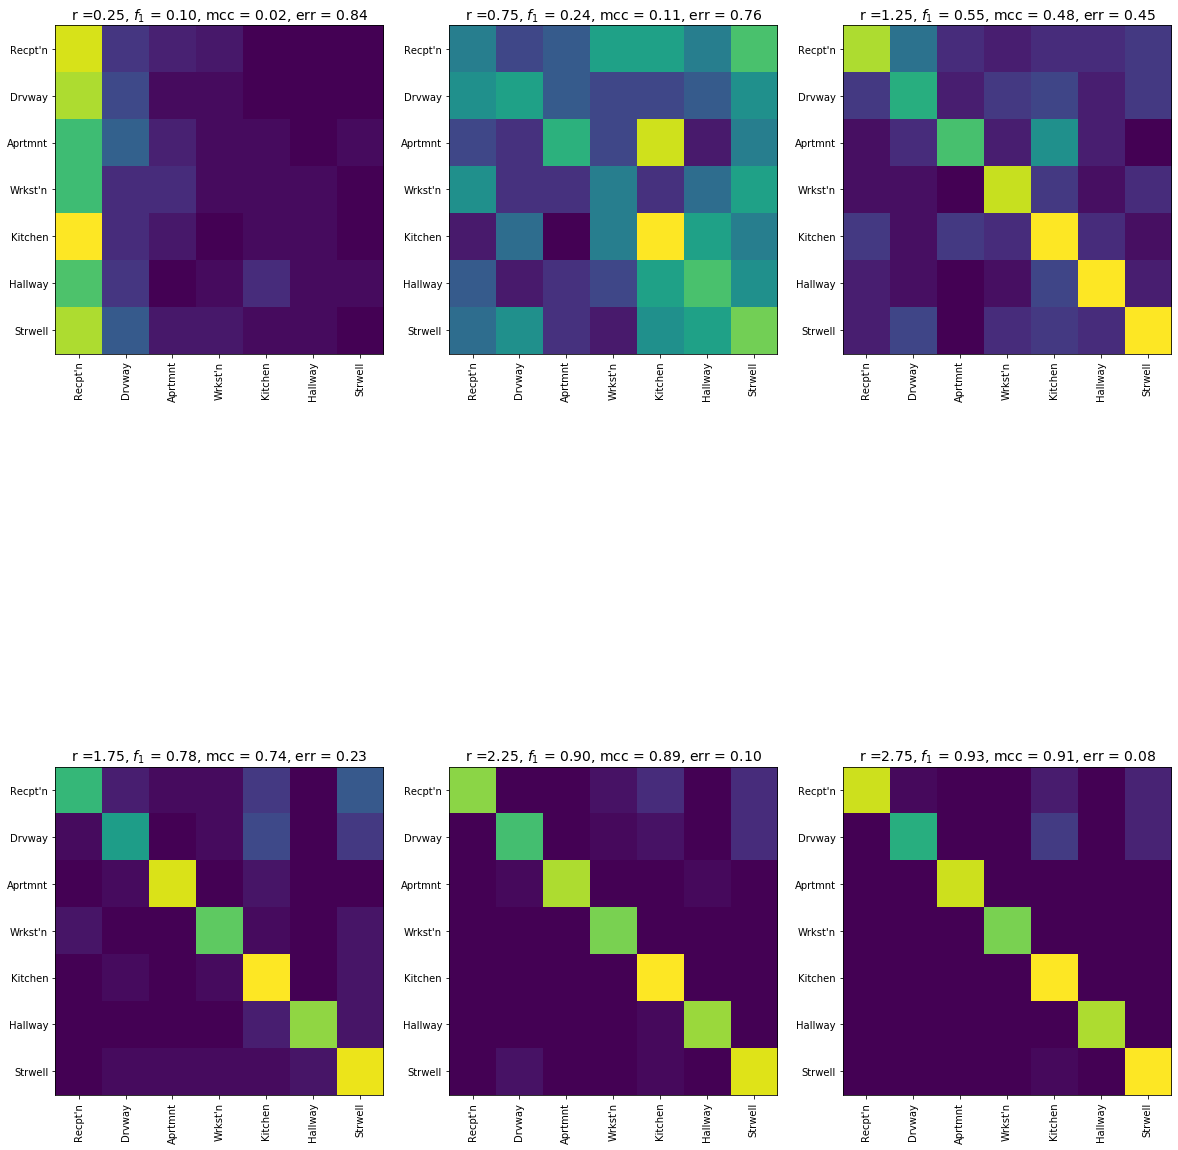

In [70]:
fig=plt.figure(figsize=(20, 25))

plot_count = 1

per_space_score = []
perf_scores = []

#desired_r = [0.5, 1.0, 3.0]

for radius, partial_errors in ransac_errors:

    score_map = np.zeros((7,7))

    for score in partial_errors:
        score_map[int(score[0]),int(score[3])]+=1
        
    macro_score = f1_score(partial_errors[:,0],partial_errors[:,3],average='macro')
    micro_score = f1_score(partial_errors[:,0],partial_errors[:,3],average='micro')
    mcc = matthews_corrcoef(partial_errors[:,0],partial_errors[:,3])
    ave_prec_score = precision_score(partial_errors[:,0],partial_errors[:,3],average='macro')
    prec_score = precision_score(partial_errors[:,0],partial_errors[:,3],average=None)
    ave_recl_score = recall_score(partial_errors[:,0],partial_errors[:,3],average='macro')
    recl_score = recall_score(partial_errors[:,0],partial_errors[:,3],average=None)
    
    per_space_score.append([
        f1_score(partial_errors[:,0],partial_errors[:,3],average=None),
        prec_score,
        recl_score
    ])
    
    perf_scores.append([
        radius,
        macro_score,
        micro_score,
        mcc,
        (np.sum(score_map) - np.trace(score_map))/np.sum(score_map)
    ])
    
    ax = fig.add_subplot(2,3,plot_count)
    #print(radius,plot_count)
    title = "r ={:.2f}, $f_1$ = {:.2f}, mcc = {:.2f}, err = {:.2f}".format(
        radius,macro_score,mcc,
        (np.sum(score_map) - np.trace(score_map))/np.sum(score_map)
    )
    ax.set_title(title, fontsize = 14)
    im = ax.imshow(score_map)#, aspect = 30)
    
    ax.set_yticks(np.arange(0,7,1))
    ax.set_yticklabels(contiguous_names_short,fontsize = 10)
    ax.set_xticks(np.arange(0,7,1))
    ax.set_xticklabels(contiguous_names_short,fontsize = 10, rotation = 90)
    
    plot_count +=1
    
per_space_score = np.asarray(per_space_score)
perf_scores = np.asarray(perf_scores)

#plt.savefig('plots/partials-Raw-heatmaps.pdf', format='pdf', dpi=300,bbox_inches = 'tight')

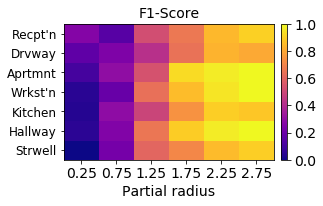

In [88]:
fig=plt.figure(figsize=(4,2.5))

ax1 = fig.add_subplot(1,1,1)

im1 = ax1.imshow(
    per_space_score[:,0].T,
    vmin=0, vmax=1.0, aspect='auto',
    cmap = plt.cm.plasma
)

# Create divider for existing axes instance
divider1 = make_axes_locatable(ax1)
# Append axes to the right of ax3, with 20% width of ax3
cax1 = divider1.append_axes("right", size="3%", pad=0.1)

# Create colorbar in the appended axes
# Tick locations can be set with the kwarg `ticks`
# and the format of the ticklabels with kwarg `format`
cbar1 = plt.colorbar(im1, cax=cax1, ticks=np.arange(0,1.6,0.2), format="%.2f")
#cbar1.ax.set_ylabel("F1-score", fontsize = 14)
cbar1.ax.set_yticklabels(np.arange(0,1.6,0.2, dtype = np.float32),fontsize = 14)

#cbar = plt.colorbar(ticks = np.arange(0,1.1,0.2))
#cbar.ax.set_ylabel("F1-score", fontsize = 14)
#cbar.ax.set_yticklabels(np.arange(0,1.1,0.2, dtype = np.float32),fontsize = 14)

ax1.set_title('F1-Score', fontsize = 14)
ax1.set_xticks(np.arange(0,6))
ax1.set_xticklabels(np.arange(0.25, 3.0, 0.5),fontsize = 14)
ax1.set_xlabel('Partial radius', fontsize = 14)
ax1.set_yticks(np.arange(0,7,1))
#plt.yticks(np.arange(0,7,1),contiguous_names_short,fontsize = 12)
ax1.set_yticklabels(contiguous_names_short,fontsize = 12)
#plt.yticklabels(

#plt.xlabel('Partial radius', fontsize = 14)
#plt.xticks(np.arange(0,6),np.arange(0.25, 1.6, 0.25),fontsize = 14)
plt.show()


In [ ]:
with open('../../mr-3d/many_ransac_generalizedPointCollection.pickle','rb') as f:
    many_ransac_generalizedPointCollection = pickle.load(f)
    
space = 3
sample = 5

fig=plt.figure(figsize=(20, 20)) ##fig=plt.figure(figsize=(80, 80))

descriptor_resolution = 10

ax0 = fig.add_subplot(3,3,1, projection='3d')
ax0.set_xlabel('X')
ax0.set_ylabel('Z')
ax0.set_zlabel('Y')
ax0.set_zlim(-1.5,1)
ax0.set_title('Dense Point Cloud')

ax1 = fig.add_subplot(3,3,3, projection='3d')
ax1.set_xlabel('X')
ax1.set_ylabel('Z')
ax1.set_zlabel('Y')
ax1.set_zlim(-1.5,1)
ax1.set_title('Surfaces')

ax4 = fig.add_subplot(3,3,2, projection='3d')
ax4.set_xlabel('X')
ax4.set_ylabel('Z')
ax4.set_zlabel('Y')
ax4.set_zlim(-1.5,1)
ax4.set_title('Normal vectors')

object_name =  many_ransac_generalizedPointCollection[space][0]
pointCloud = np.asarray(many_ransac_generalizedPointCollection[space][1][sample][0])
triangles = np.asarray(many_ransac_generalizedPointCollection[space][1][sample][1])

#pointCloud = np.concatenate((pointCloud,normals),axis = 1)

t0 = time.time()

pointCloud = getQuantizedPointCloudOnlyTEST(pointCloud, scale=100)
generalized_planes = getRansacPlanes2(pointCloud)

#print(pointCloud.shape)

X = pointCloud[:,0]
Y = pointCloud[:,1]
Z = pointCloud[:,2]

ax0.set_xlim(min(X), max(X))
ax0.set_ylim(min(-Z), max(-Z))
ax1.set_xlim(min(X), max(X))
ax1.set_ylim(min(-Z), max(-Z))

print(object_name,pointCloud.shape, triangles.shape, len(generalized_planes))

for plane_params, points, refpoint in generalized_planes:
    
    bestPlane = plane_params[0]
    phi = plane_params[1]
    density = plane_params[2]
    
    #triangles = plane_[2]
    triangles = getDelaunayTriangles(
        bestPlane, 
        points,
        #triangle_area_threshold = triangle_area_threshold,
        #phi = phi,
        #strict = strict,
        #verbose = verbose
    )

    if len(triangles) == 0:
        if verbose: print("No triangles at",bestPlane,len(planes),points.shape)
        continue

    PX = points[:,0]
    PY = points[:,1]
    PZ = points[:,2]

    #if strict:
    # Get area and point desity of the planes
    v1 = points[triangles[:,0],:3] - points[triangles[:,1],:3]
    v2 = points[triangles[:,2],:3] - points[triangles[:,1],:3]
    area = np.abs(LA.norm(np.cross(v1,v2), axis = 1))*0.5
    point_density = len(points)/np.nansum(area)

    #if verbose: 
    print("Plane area {:.3f}; point density {:.3f}.".format(np.nansum(area),point_density))

    if point_density < 100: #0.75*density:
        continue

    if phi > 0.5 :
        print("horizontal at",phi,bestPlane[3:])
        hull = ConvexHull(points[:,0:3:2])
    else:
        print("vertical at",phi,bestPlane[3:])
        hull = ConvexHull(points[:,0:2:1])
    
    #p_pointCloud = pointCloud[np.where(np.around(pointCloud[:,3:],decimals = 2) == normal)[0]]
    h_pointCloud = points[hull.vertices]

    PX = np.concatenate((h_pointCloud, [h_pointCloud[0]]), axis = 0)[:,0]
    PY = np.concatenate((h_pointCloud, [h_pointCloud[0]]), axis = 0)[:,1]
    PZ = np.concatenate((h_pointCloud, [h_pointCloud[0]]), axis = 0)[:,2]

    #ax0.plot3D(PX,-PZ,PY,'k-',alpha = 0.7)
    ax1.plot3D(
        PX,-PZ,PY,
        'k-', linewidth = 2,
        alpha = 0.7)

print()
try:
    imT = ax0.scatter(
        X,-Z,Y,
        c = Y,
        cmap = mpl.cm.viridis,
        alpha = 0.5
    )#,c=t_l_s_[:,-1])
    
    ax4.plot_trisurf(X, -Z, Y, triangles=triangles, cmap=plt.cm.Spectral)

    #imT.set_clim(0.0, 1.0)
    #cbarT = fig.colorbar(imT, ax=ax0)
    #cbarT.ax.set_ylabel('Local self-similarity ({} neighbors)'.format(len(t_k_[0])))

    #ax1.plot_trisurf(X, -Z, Y, triangles=triangles, cmap=plt.cm.Spectral)

    #ax4.quiver(X, -Z, Y,
    #           pointCloud[:,3], -pointCloud[:,4], pointCloud[:,5],length=0.1)#, cmap=plt.cm.Spectral)

except Exception as ex:
    print(ex)
    pass

ax0.set_axis_off()
ax1.set_axis_off()